**Last Updated 16/8/2023:**

The goal in this notebook is simple, to test some of the ideas in this paper [here](https://static1.squarespace.com/static/59d5ac1780bd5ef9c396eda6/t/64d19ef04f09367a678e096b/1691459312179/ID66_Research+Paper_2023.pdf). Importantly, the use of CNNs to deal with tabular data is proposed in the paper. 

Further goals in this notebook would be to explore the various mechanisms in TabNet. ChatGPT gives a summary of the mechanisms: 
1. Attentive Feature Selection:
- TabNet uses sequential attention mechanisms to determine which features should be attended to and propagated through the network. The model dynamically selects features that are most relevant for making accurate predictions. This is achieved through a step-by-step process:
    - During each decision step, the model computes attention scores for all input features. These scores indicate the importance of each feature for the current decision.
    - The attention scores are used to guide the flow of information through subsequent layers, ensuring that important features are retained while less relevant features are suppressed.
2. Gating Mechanisms:
    - Gating mechanisms are integral to TabNet's architecture and play a crucial role in controlling the flow of information within the network. Two types of gating mechanisms are used:
        - Feature Gating: This mechanism decides which features should be passed along to subsequent layers. It selectively gates the input features based on their importance, as determined by the attention mechanism. Features with higher attention scores are more likely to be passed through.

        - Output Gating: Output gating controls the information flow from one decision step to the next. It ensures that relevant information is retained and passed along while filtering out noise and irrelevant signals.

3. Sparsemax Activation:
    - The Sparsemax activation function is employed in TabNet to encourage sparsity in attention weights. Unlike traditional softmax, which distributes attention relatively evenly among features, sparsemax allocates attention more selectively. This sparsity property allows the model to focus on a smaller subset of important features for each decision, leading to improved interpretability and potentially reducing overfitting.

4. Decision Trees:
    - Decision trees are integrated into TabNet's architecture to aid in both feature selection and modeling complex interactions. These trees help the model capture non-linear relationships and interactions between features. The decision trees contribute to the overall decision-making process by allowing the model to learn and adapt to the underlying patterns in the data.

# Load Packages, Variables

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import gc

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import gcsfs

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle


from ficc.utils.nelson_siegel_model import *
from ficc.utils.diff_in_days import *
from ficc.utils.auxiliary_functions import sqltodf


from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT, NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

import sys
sys.path.append('../')
from ficc_keras_utils import *
import ficc_keras_utils
from lgbm_tools import *
from ficc_debiasing import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'TF Version: {tf.__version__}')

2023-08-16 16:36:11.880658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-16 16:36:12.096682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-16 16:36:12.098845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
TF Version: 2.7.0


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

##COMMON VARIABLES
#DATA WINDOW
train_start = '2023-01-01'
train_end = '2023-06-01'
test_start = '2023-06-01'
test_end = '2023-07-01'
#MODEL PARAMETERS 
VALIDATION_SPLIT = 0.1
LEARNING_RATE = ficc_keras_utils.LEARNING_RATE
BATCH_SIZE = 1000 #ficc_keras_utils.BATCH_SIZE
NUM_EPOCHS = 75 #ficc_keras_utils.NUM_EPOCHS
DROPOUT = 0.25 #ficc_keras_utils.DROPOUT

##NOTEBOOK SPECIFIC VARIABLES 
TRADE_SEQUENCE_LENGTH = 5
NUM_FEATURES = 6
# target_variable = 'new_ys_diff'
# target_variable = 'new_ys' 
target_variable = 'new_ys' 

In [3]:
print(train_start ,
train_end ,
test_start ,
test_end)

2023-01-01 2023-06-01 2023-06-01 2023-07-01


# Load Data and Train NN

In [4]:
def load_data_from_pickle(path, bucket = 'isaac_data'):
    if os.path.isfile(path):
        print('File available, loading pickle')
        with open(path, 'rb') as f:
            data = pickle.load(f)
    else:
        print(f'File not available, downloading from cloud storage and saving to {path}')
        fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
        gc_path = os.path.join(bucket, path)
        print(gc_path)
        with fs.open(gc_path) as gf:
            data = pd.read_pickle(gf)
        with open(path, 'wb') as f:
            pickle.dump(data, f)
    return data

In [5]:
%time processed_data = load_data_from_pickle('processed_data_2023-07-24-14:53.pkl', 'ficc_training_data_latest')

File available, loading pickle
CPU times: user 16.6 s, sys: 8.29 s, total: 24.9 s
Wall time: 58.1 s


In [6]:
processed_data.trade_history.apply(lambda x: x.shape).value_counts()

(10, 6)    4496783
Name: trade_history, dtype: int64

In [7]:
processed_data.target_attention_features.apply(lambda x: x.shape).value_counts()

(1, 3)    4496783
Name: target_attention_features, dtype: int64

In [8]:
processed_data.sort_values('trade_datetime', inplace=True)

## Checking data

In [9]:
processed_data.trade_date.min(), processed_data.trade_date.max()

(Timestamp('2023-01-03 00:00:00'), Timestamp('2023-06-30 00:00:00'))

In [10]:
processed_data[['yield','new_real_time_ficc_ycl']].describe()

,yield,new_real_time_ficc_ycl
count,4496783.000,4456073.000
mean,351.854,303.491
std,91.926,52.937
min,0.100,222.526
25%,290.000,265.675
50%,338.500,296.133
75%,407.400,324.551
max,9892.500,559.034


In [11]:
processed_data.reset_index(drop=True, inplace=True)

In [12]:
def process_data(data): 
    # data['ted-rate'] = (data['t_rate_10'] - data['t_rate_2']) * 100
    
    data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
    data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
    data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > np.log10(400))]
    data = data[data.days_to_maturity < np.log10(30000)]
    data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))
    data.issue_amount = data.issue_amount.replace([np.inf, -np.inf], np.nan)
    data.dropna(inplace=True, subset=PREDICTORS+['trade_history_sum'])
    
    return data

In [13]:
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

ys_variants = ["max_ys", "min_ys", "max_qty", "min_ago", "D_min_ago", "P_min_ago", "S_min_ago"]
ys_feats = ["_ys", "_ttypes", "_ago", "_qdiff"]
D_prev = dict()
P_prev = dict()
S_prev = dict()

def get_trade_history_columns():
    '''
    This function is used to create a list of columns
    '''
    YS_COLS = []
    for prefix in ys_variants:
        for suffix in ys_feats:
            YS_COLS.append(prefix + suffix)
    return YS_COLS

def extract_feature_from_trade(row, name, trade):
    yield_spread = trade[0]
    ttypes = ttype_dict[(trade[3],trade[4])] + row.trade_type
    seconds_ago = trade[5]
    diff = 10**trade[2] - 10**row.quantity
    quantity_diff = np.sign(diff) * np.log10(1 + np.abs(diff))
    return [yield_spread, ttypes,  seconds_ago, quantity_diff]

def trade_history_derived_features(row):
    trade_history = row.trade_history
    trade = trade_history[0]
    
    D_min_ago_t = D_prev.get(row.cusip,trade)
    D_min_ago = 9        

    P_min_ago_t = P_prev.get(row.cusip,trade)
    P_min_ago = 9
    
    S_min_ago_t = S_prev.get(row.cusip,trade)
    S_min_ago = 9
    
    max_ys_t = trade; max_ys = trade[0]
    min_ys_t = trade; min_ys = trade[0]
    max_qty_t = trade; max_qty = trade[2]
    min_ago_t = trade; min_ago = trade[5]
    
    for trade in trade_history[0:]:
        #Checking if the first trade in the history is from the same block
        if trade[5] == 0: 
            continue
 
        if trade[0] > max_ys: 
            max_ys_t = trade
            max_ys = trade[0]
        elif trade[0] < min_ys: 
            min_ys_t = trade; 
            min_ys = trade[0]

        if trade[2] > max_qty: 
            max_qty_t = trade 
            max_qty = trade[2]
        if trade[5] < min_ago: 
            min_ago_t = trade; 
            min_ago = trade[5]
            
        side = ttype_dict[(trade[3],trade[4])]
        if side == "D":
            if trade[5] < D_min_ago: 
                D_min_ago_t = trade; D_min_ago = trade[5]
                D_prev[row.cusip] = trade
        elif side == "P":
            if trade[5] < P_min_ago: 
                P_min_ago_t = trade; P_min_ago = trade[5]
                P_prev[row.cusip] = trade
        elif side == "S":
            if trade[5] < S_min_ago: 
                S_min_ago_t = trade; S_min_ago = trade[5]
                S_prev[row.cusip] = trade
        else: 
            print("invalid side", trade)
    
    trade_history_dict = {"max_ys":max_ys_t,
                          "min_ys":min_ys_t,
                          "max_qty":max_qty_t,
                          "min_ago":min_ago_t,
                          "D_min_ago":D_min_ago_t,
                          "P_min_ago":P_min_ago_t,
                          "S_min_ago":S_min_ago_t}

    return_list = []
    for variant in ys_variants:
        feature_list = extract_feature_from_trade(row,variant,trade_history_dict[variant])
        return_list += feature_list
    
    return return_list

In [14]:
%%time
temp = processed_data[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
YS_COLS = get_trade_history_columns()
processed_data[YS_COLS] = pd.DataFrame(temp.tolist(), index=processed_data.index)

CPU times: user 1min 50s, sys: 17.5 s, total: 2min 8s
Wall time: 4min 8s


In [15]:
%%time
processed_data['ttypes'] = (processed_data.last_trade_type.astype(str) + processed_data.trade_type.astype(str)).astype('category')
processed_data['diff_size'] = (processed_data.par_traded.astype(float) - processed_data.last_size).astype(np.float32)
processed_data['abs_last_yield_spread'] = np.abs(processed_data['last_yield_spread'])
processed_data['abs_diff_size'] = np.abs(processed_data['diff_size'])
processed_data['days_duration'] = (processed_data.last_calc_date - processed_data.last_settlement_date).dt.days

CPU times: user 936 ms, sys: 112 ms, total: 1.05 s
Wall time: 1.05 s


In [16]:
%%time
processed_data['trade_history_sum'] = processed_data.trade_history.parallel_apply(lambda x: np.sum(x))
processed_data = processed_data.dropna(subset=['trade_history_sum'])
processed_data.purpose_sub_class.fillna(0, inplace=True)

CPU times: user 32.9 s, sys: 15.6 s, total: 48.5 s
Wall time: 58.7 s


In [17]:
for col in ['new_ficc_ycl', 'yield_spread']:
    if col in NON_CAT_FEATURES:
        NON_CAT_FEATURES.remove(col)
    if col in PREDICTORS:
        PREDICTORS.remove(col)

In [18]:
%%time 

processed_data = process_data(processed_data)

CPU times: user 45.2 s, sys: 16.7 s, total: 1min 1s
Wall time: 1min 6s


In [27]:
# def modify_features(cols, how, where=None):
#     global CATEGORICAL_FEATURES, PREDICTORS, NON_CAT_FEATURES, BINARY
    
#     if how not in ['add','remove']:
#         raise ValueError(f"'how' argument must be one off the following: {['add','remove']}")
        
#     if where and where not in ['categorical','binary', 'numeric']:
#         raise ValueError(f"'where' argument must be one off the following: {['categorical','binary', 'numeric']}")
    
#     if how == 'remove':
#         for col in cols: 
#             if col in CATEGORICAL_FEATURES:
#                 CATEGORICAL_FEATURES.remove(col)
#             if col in BINARY:
#                 BINARY.remove(col)
#             if col in NON_CAT_FEATURES:
#                 NON_CAT_FEATURES.remove(col)
#             if col in PREDICTORS:
#                 PREDICTORS.remove(col)
            
#     if how == 'add':
#         for col in cols: 
#             if col not in CATEGORICAL_FEATURES and where=='categorical':
#                 CATEGORICAL_FEATURES.append(col)
#             if col not in BINARY and where=='binary':
#                 BINARY.append(col)
#             if col not in NON_CAT_FEATURES and where=='numeric':
#                 NON_CAT_FEATURES.append(col)
#             if col not in PREDICTORS:
#                 PREDICTORS.append(col)

In [52]:
# modify_features(['rating','moodys_rating','ratings_concat'], how = 'remove')
# # modify_features(['ratings_concat'], how = 'add', where='categorical')
# modify_features(['rating'], how = 'add', where='categorical')
# # modify_features(['rating','moodys_rating'], how = 'add')

In [19]:
CATEGORICAL_FEATURES

['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']

In [20]:
additional_features = ['ttypes', 'diff_size', 'abs_last_yield_spread', 'abs_diff_size', 'days_duration']
YS_COLS = ['max_ys_ys', 'max_ys_ttypes', 'max_ys_ago', 'max_ys_qdiff', 'min_ys_ys', 'min_ys_ttypes', 'min_ys_ago', 'min_ys_qdiff', 'max_qty_ys', 'max_qty_ttypes', \
           'max_qty_ago', 'max_qty_qdiff', 'min_ago_ys', 'min_ago_ttypes', 'min_ago_ago', 'min_ago_qdiff', 'D_min_ago_ys', 'D_min_ago_ttypes', 'D_min_ago_ago', 'D_min_ago_qdiff',\
           'P_min_ago_ys', 'P_min_ago_ttypes', 'P_min_ago_ago', 'P_min_ago_qdiff', 'S_min_ago_ys', 'S_min_ago_ttypes', 'S_min_ago_ago', 'S_min_ago_qdiff']
    
for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)
        
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')
    
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')
    
#these harm accuracy so we delete them 
for col in ['new_ficc_ycl', 'new_real_time_ficc_ycl']:     
    if col in PREDICTORS:
        PREDICTORS.remove(col)
    if col in NON_CAT_FEATURES:
        NON_CAT_FEATURES.remove(col)

encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
trade_type
purpose_class
max_ys_ttypes
min_ys_ttypes
max_qty_ttypes
min_ago_ttypes
D_min_ago_ttypes
P_min_ago_ttypes
S_min_ago_ttypes


In [21]:
%%time
TRADE_SEQUENCE_LENGTH = 5 
processed_data['trade_history_shortened'] = processed_data['trade_history'].apply(lambda x: x[:TRADE_SEQUENCE_LENGTH])

CPU times: user 2.31 s, sys: 33.4 ms, total: 2.35 s
Wall time: 2.35 s


In [22]:
processed_data['trade_history_shortened'].apply(lambda x: x.shape).value_counts()

(5, 6)    4080954
Name: trade_history_shortened, dtype: int64

In [23]:
processed_data.trade_date.min(), processed_data.trade_date.max(), len(processed_data)

(Timestamp('2023-01-03 00:00:00'), Timestamp('2023-06-30 00:00:00'), 4080954)

In [24]:
processed_data.sort_values('trade_datetime',ascending=False,inplace=True)

In [25]:
train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <test_end)
                                                            
train_dataframe = processed_data[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

print('Training data start: {}, end: {}'.format(train_dataframe.trade_date.min(),train_dataframe.trade_date.max()))
print('Test data start: {}, end: {}'.format(test_dataframe.trade_date.min(),test_dataframe.trade_date.max()))

Training data start: 2023-01-03 00:00:00, end: 2023-05-31 00:00:00
Test data start: 2023-06-01 00:00:00, end: 2023-06-30 00:00:00


In [43]:
20*20

400

In [49]:
32*32

1024

In [59]:
def create_input_new(df, trade_history_col, yield_history_cols):
    global encoders
    datalist = []
    
        
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

def generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history,
                      yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[num_yield_history+2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[num_yield_history]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)
    
    ### CONCATENATE EMBEDDINGS
    reference_hidden = layers.Dense(1024,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.Dropout(DROPOUT/2)(reference_hidden)
    reference_hidden = layers.Reshape((32, 32,1))(reference_hidden)
    conv_1 = layers.Conv2D(32, (4,4))(reference_hidden)
    pool_1 = layers.MaxPooling2D((2,2))(conv_1)
    
    
    hidden_1 = layers.Dense(512)(layers.Flatten()(pool_1))
    hidden_1 = layers.Reshape((32,16,1))(hidden_1)
    conv_2 = layers.Conv2D(16, (4,4))(hidden_1)
    pool_2 = layers.MaxPooling2D((2,2))(conv_2)
    
    hidden_2 = layers.Dense(256)(layers.Flatten()(pool_2))
    hidden_2 = layers.Reshape((16,16,1))(hidden_2)
    conv_3 = layers.Conv2D(8, (4,4))(hidden_2)
    pool_3 = layers.MaxPooling2D((2,2))(conv_3)

    reference_output = layers.Flatten()(pool_3)

    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])
    feed_forward_input = layers.Dropout(DROPOUT)(feed_forward_input)
    
    hidden = layers.Dense(300,activation='relu')(feed_forward_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)
    
    hidden = layers.Dense(200,activation='relu')(hidden)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)

    hidden2 = layers.Dense(100,activation='relu')(hidden)
    hidden2 = layers.BatchNormalization()(hidden2)
    hidden2 = layers.Dropout(DROPOUT)(hidden2)

    final = layers.Dense(1)(hidden2)

    model = keras.Model(inputs=inputs, outputs=final)
    
    return model


def create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    if isinstance(yield_history_cols, str):
        num_yield_history = 1
        yield_history_cols = [yield_history_cols]
    else:
        num_yield_history = len(yield_history_cols)
    
    yield_history_lengths = [train_dataframe[x][0].shape[0] for x in yield_history_cols]
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH, 
           'yield_history_cols':yield_history_cols, 
           'yield_history_lengths':yield_history_lengths, 
           'num_yield_history':num_yield_history }
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input_new(train_dataframe.drop(val_idx, axis=0), trade_history_col, yield_history_cols)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input_new(train_dataframe.iloc[val_idx], trade_history_col, yield_history_cols)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input_new(test_dataframe, trade_history_col, yield_history_cols)
    y_test = test_dataframe[target_variable]    
    
    # Normalization layer for the yield history
    yield_history_normalizers = []
    for i in range(num_yield_history):
        yield_history_normalizers.append(Normalization(name=f'Yield_history_normalizer_{yield_history_cols[i]}'))
        yield_history_normalizers[i].adapt(x_train[i],batch_size=BATCH_SIZE)
    
    with tf.device('/cpu:0'):
        # Normalization layer for the trade history
        trade_history_normalizer = Normalization(name='Trade_history_normalizer')
        trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

        # Normalization layer for the non-categorical and binary features
        noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
        noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

    normalizers = {'yield_history_normalizers': yield_history_normalizers,
                  'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx



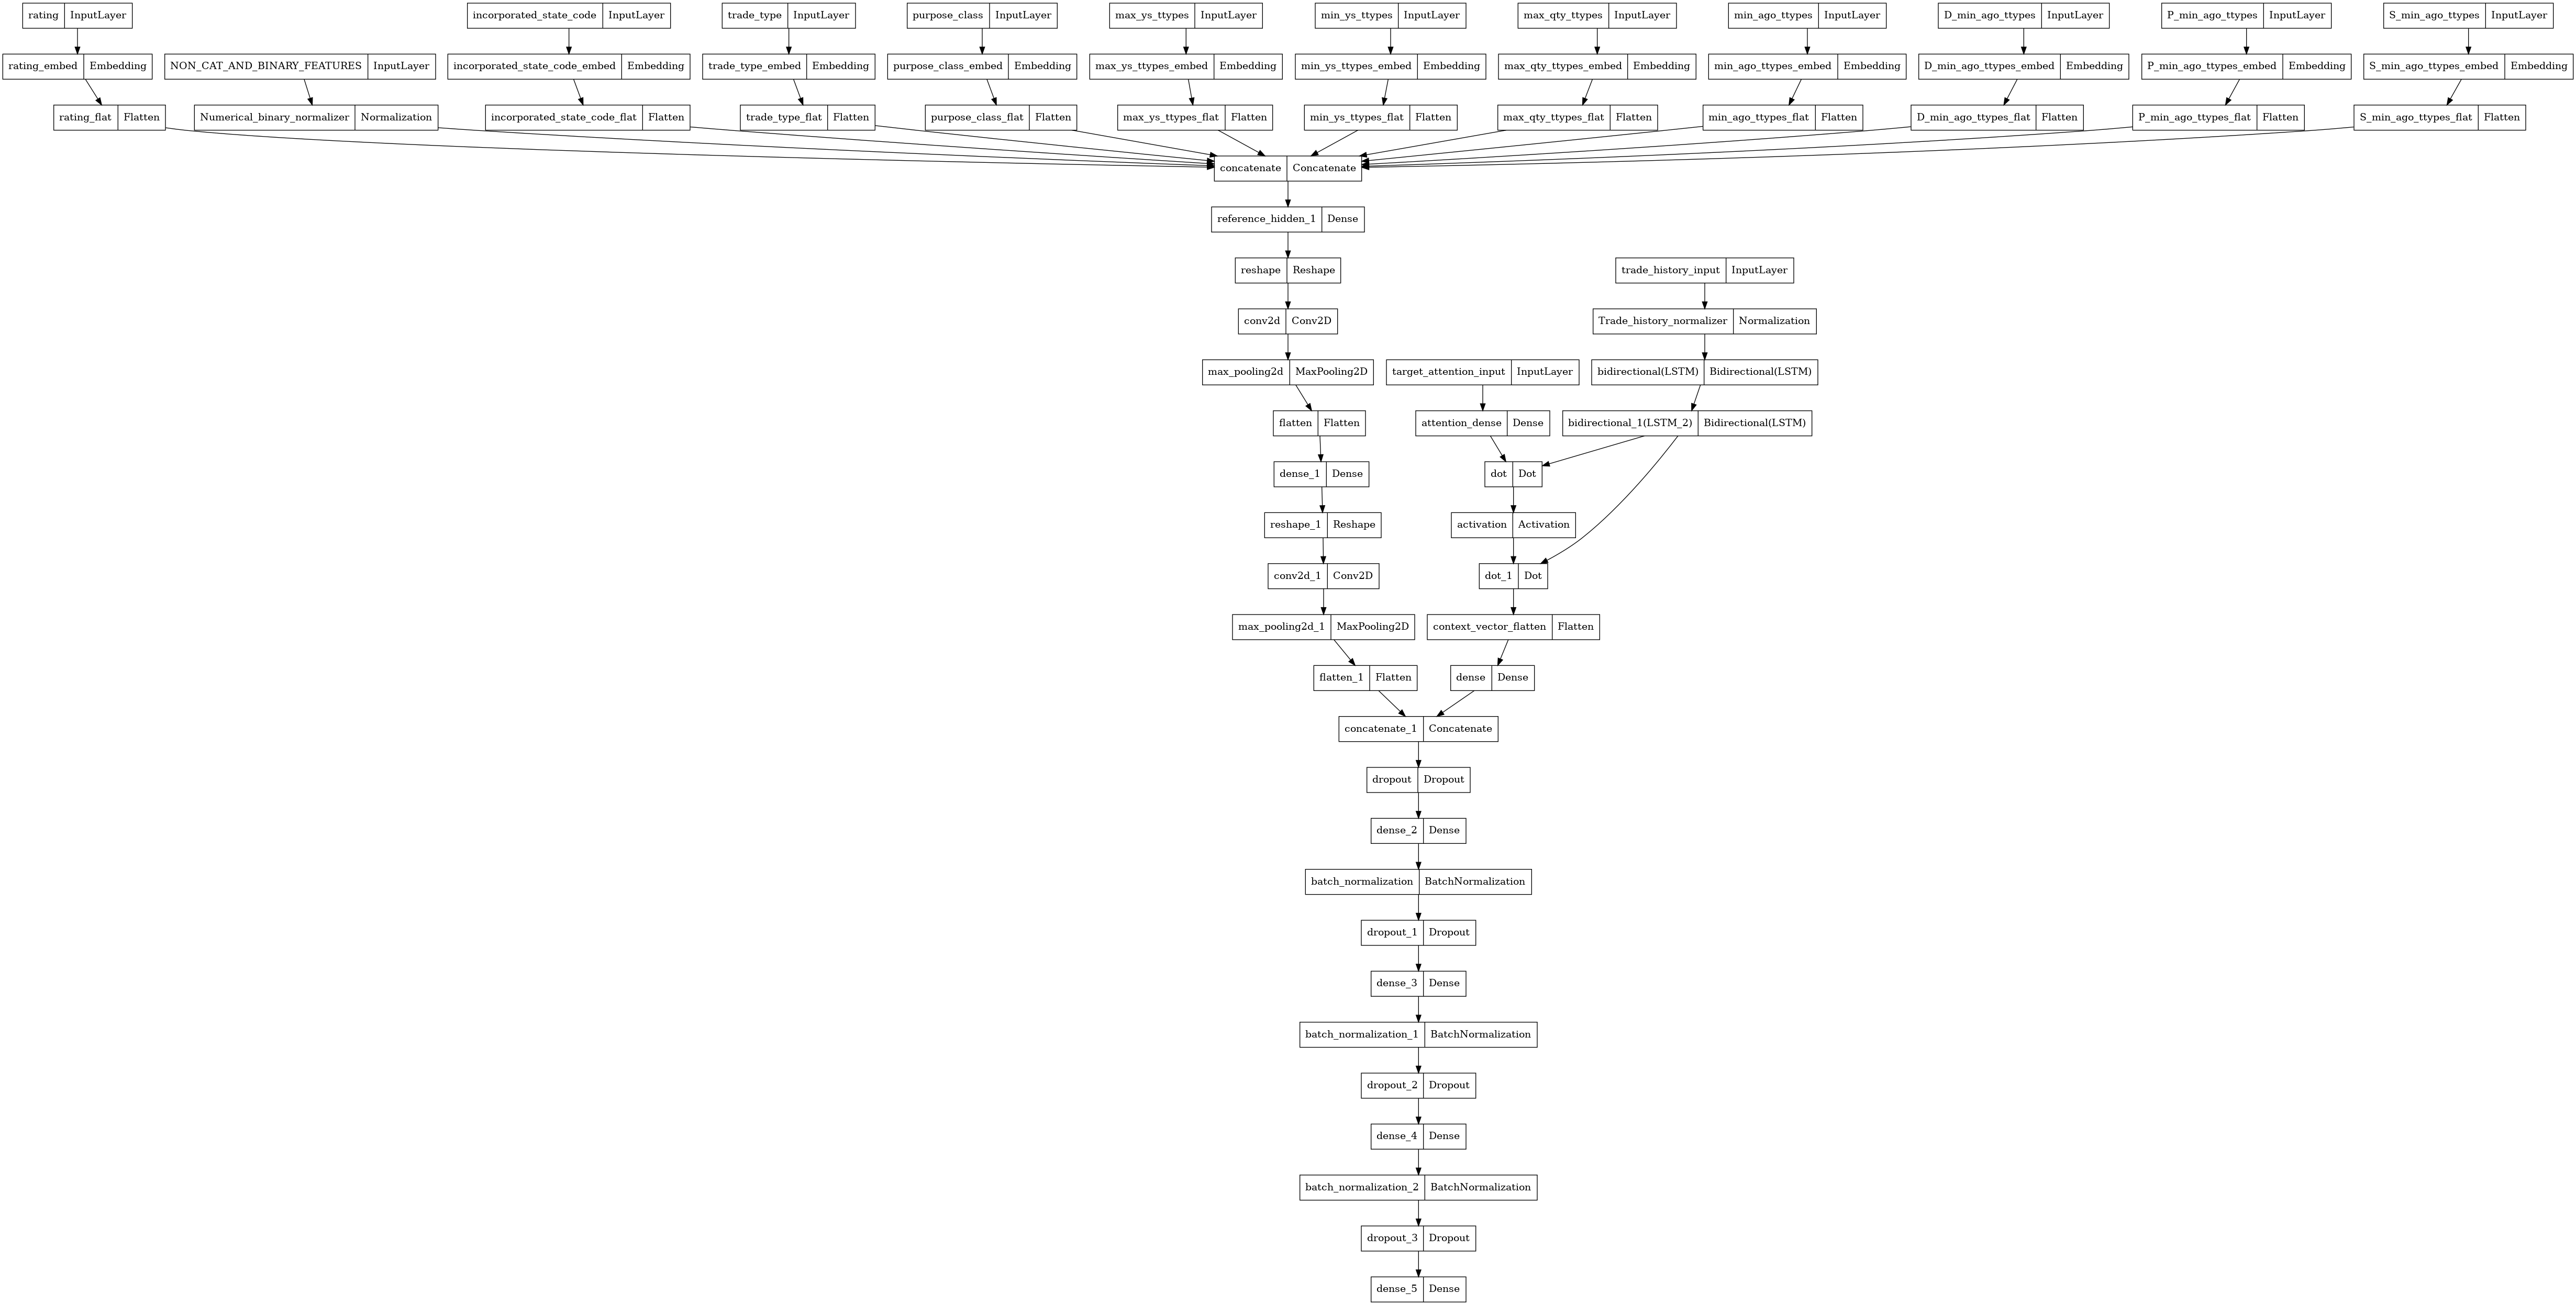

In [50]:
keras.utils.plot_model(model)

In [27]:
def create_tf_data(x_train, y_train, shuffle=False, shuffle_buffer=1):
                     
    X=()
    for x in x_train:
        X += (tf.data.Dataset.from_tensor_slices(x),)
        

    temp = tf.data.Dataset.zip((X))
    del X
    dataset = tf.data.Dataset.zip((temp,
                        tf.data.Dataset.from_tensor_slices(y_train)))
    del temp
    if shuffle:
        shuffle_buffer = int(len(x_train[0])*shuffle_buffer)
        dataset = dataset.shuffle(shuffle_buffer)
        
    return dataset

In [55]:
def train_model_new(params, normalizers, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1):
    tf.keras.backend.clear_session()
    gc.collect()

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    yield_history_cols = params.get('yield_history_cols')
    yield_history_lengths = params.get('yield_history_lengths')
    num_yield_history = params.get('num_yield_history')
      
    yield_history_normalizers = normalizers.get('yield_history_normalizers')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    model = generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                               yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer)
    
    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        # time_callback,
        CSVLoggerTimeHistory(timestamp+'_training_logs_yield_history.csv', separator=",", append=False)]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(5000).prefetch(2).cache()
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError())

    history= model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=1, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, model
    
    # return model



In [29]:
trade_history_col = 'trade_history_shortened'
yield_history_cols = []

In [30]:
# params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols)
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols)

TRAINING DATA: N = 3024352, MIN DATE = 2023-01-03 00:00:00, MAX DATE = 2023-05-31 00:00:00
VALIDATION DATA: N = 336039, MIN DATE = 2023-01-03 00:00:00, MAX DATE = 2023-05-31 00:00:00
TEST DATA: N = 720563, MIN DATE = 2023-06-01 00:00:00, MAX DATE = 2023-06-30 00:00:00


2023-08-16 16:44:52.752772: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 16:44:52.781648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-16 16:44:52.785325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-16 16:44:52.787966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [31]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape)

14
(3024352, 5, 6)
(3024352, 1, 3)
(3024352, 48)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)


In [ ]:
results = []
predictions = []
NUM_EPOCHS = 100

for i in range(1):
    tf.keras.utils.set_random_seed(10)
    start = time.time()
    history, model = train_model_new(params, normalizers, x_train, y_train, x_val, y_val, True, shuffle_buffer = .75)
    model.save(f'baseline_ensemble_CNN_{i}')
    pred = model.predict(x_test, batch_sze=5000)
    predictions.append(pred)
    print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
    results.append([history, model])

Epoch 1/100


2023-08-16 21:10:41.968912: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-16 21:10:52.849296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 569962 of 2268264
2023-08-16 21:11:02.849295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1082244 of 2268264
2023-08-16 2

3025/3025 [==============================] - ETA: 0s - loss: 43.5042

2023-08-16 21:13:33.110737: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


3025/3025 [==============================] - 184s 43ms/step - loss: 43.5042 - val_loss: 30.2504
Epoch 2/100
3025/3025 [==============================] - 100s 33ms/step - loss: 19.2727 - val_loss: 10.9990
Epoch 3/100
3025/3025 [==============================] - 97s 32ms/step - loss: 11.6389 - val_loss: 11.0300
Epoch 4/100
3025/3025 [==============================] - 100s 33ms/step - loss: 11.2921 - val_loss: 11.1460
Epoch 5/100
 391/3025 [==>...........................] - ETA: 1:18 - loss: 11.2877

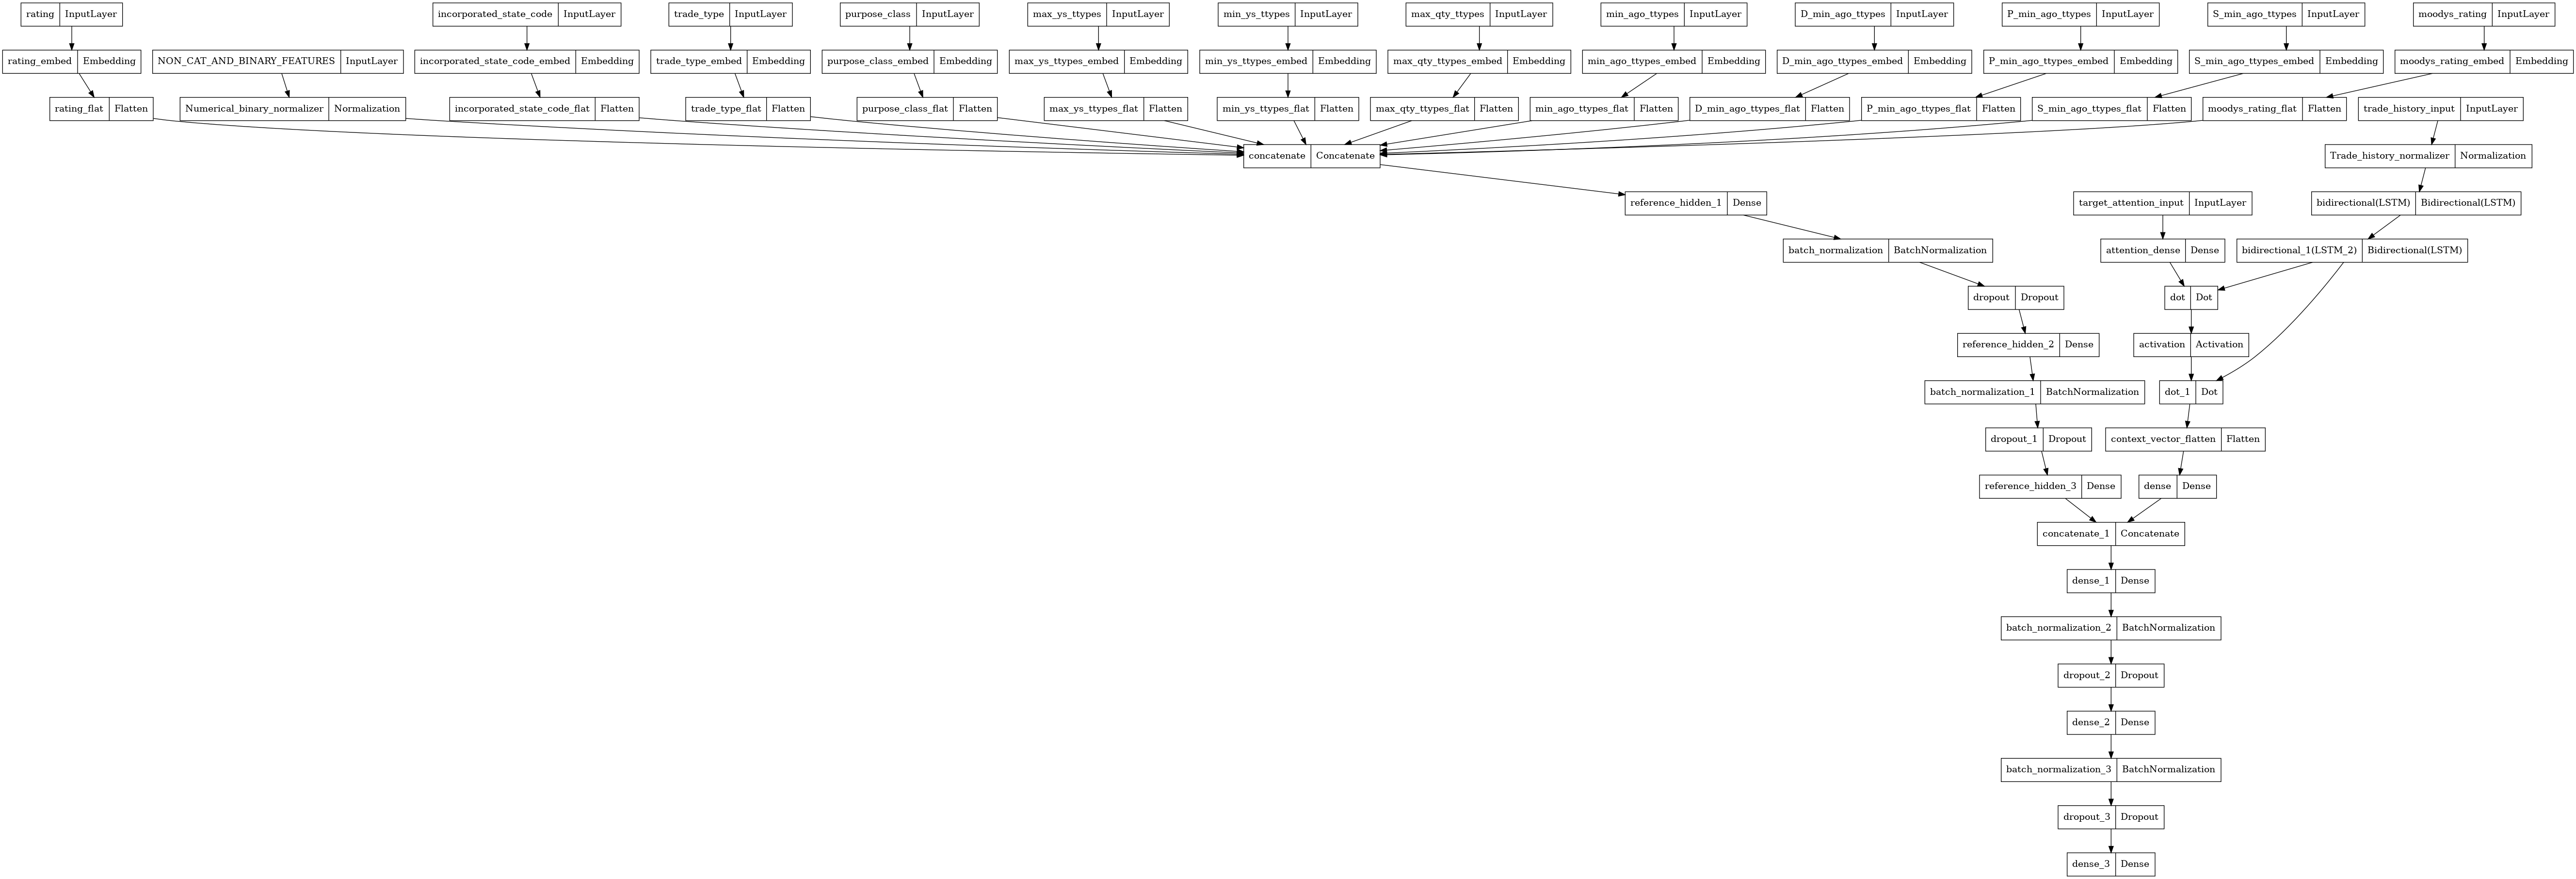

In [60]:
keras.utils.plot_model(model)

In [ ]:
# model.save('large_model_baseline_dropout0.1_final')
# model.save('large_model_baseline_moodys_dropout0.1_final')

In [62]:
predictions

[]

In [61]:
#CURRENT TRIAl 

#75 EPOCHS 
#no RESIDUAL 
#DROPOUT 0.1
#MOODYS + SP EMBEDDINGS CONCATENATED AND FED THROUGH DENSE LAYER (30)

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

ZeroDivisionError: division by zero

In [124]:
#CURRENT TRIAl 

#75 EPOCHS 
#no RESIDUAL 
#DROPOUT 0.1
#MOODYS + SP EMBEDDINGS CONCATENATED AND FED THROUGH DENSE LAYER (30)

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.196
Trial 2: 8.184
Trial 3: 8.176
Trial 4: 8.167
Average MAE: 8.181


In [68]:
#75 EPOCHS 
#BOTTLENECK 1
#NO RESIDUAL 
#DROPOUT 0.1
#MOODYS + SP EMBEDDINGS CONCATENATED AND FED THROUGH DENSE LAYER (10)

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.203
Trial 2: 8.229
Trial 3: 8.204
Trial 4: 8.221
Average MAE: 8.214


In [102]:
#75 EPOCHS 
#ORIGINAL ARCHITECTURE
#NO RESIDUAL 
#DROPOUT 0.1
#NO MOODYS
#BASELINE

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.087
Trial 2: 8.116
Trial 3: 8.120
Trial 4: 8.114
Average MAE: 8.109


In [81]:
#75 EPOCHS 
#ORIGINAL ARCHITECTURE
#NO RESIDUAL 
#DROPOUT 0.1
#MOODYS

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.097
Trial 2: 8.080
Trial 3: 8.104
Trial 4: 8.147
Average MAE: 8.107


# Pricing Hypothetical Trades

In [7]:
# synthetic_sampled_data = pd.read_pickle('synthetic_sampled_data_new.pkl')
# baseline_data = pd.read_pickle('synthetic_sampled_data_baseline.pkl')

In [35]:
def get_days(row, col):
    if pd.isna(row[col]) or pd.isna(row['settlement_date']):
        return 0
    else: 
        diff = diff_in_days_two_dates(row[col], row.settlement_date)
        if diff <= 0:
            return -1
        else:
            return diff
        
def sample_dataframe(df, N):
    '''Takes a dataframe from pd.groupby and samples N rows from it without replacement. The group name (in this case, the groupby index) is saved
    to a dictionary, groupby_id_dict'''
    
    group_name = df.name
    def index_to_dict(index_row):
        is_callable = index_row[0]
        interval = str(index_row[1].left)+'-'+str(index_row[1].right)
        rating = index_row[2]
        return {'is_callable':is_callable, 'interval': interval, 'rating':rating}
    
    df = df.drop_duplicates(subset='cusip')
    
    if len(df) < N:
        N = len(df)
    
    np.random.seed(1)
    result = df.sample(N, replace=False) 
    group_id = next(COUNT)
    result['group'] = group_id
    groupby_id_dict[group_id] = index_to_dict(group_name)
    return result


def create_synthetic_samples(df, col, vals):
    '''For a given cusip, the first trade is sampled and hypothetical trades are appended with by varying the column defined in col with values in vals'''
    for cusip in df.cusip.unique():
        for val in vals:
            temp = df[df.cusip == cusip].iloc[0] 
            if val != temp[col]:
                temp[col] = val
                df = df.append(temp)
    return df

def make_summary(col):
    '''Calculates the Max-Min range by cusip'''
    summary_df = synthetic_sampled_data.groupby(['cusip'])\
    ['predictions']\
    .agg(['std', max_min_f])\
    .rename({'<lambda_0>':'Max-Min'}, axis=1)\
    
    summary_df = summary_df.join(synthetic_sampled_data.set_index('cusip')[col])
    
    summary_df = summary_df.groupby(col).mean()
    # summary_df.columns = pd.MultiIndex.from_tuples(summary_df.columns)
    
    display(summary_df)
    
    return summary_df

In [36]:
data = test_dataframe.copy()
# data['days_to_call'] = data[['settlement_date','next_call_date']].apply(lambda x: get_days(x, 'next_call_date'), axis = 1)/NUM_OF_DAYS_IN_YEAR
data['maturity'] = data[['settlement_date','maturity_date']].apply(lambda x: get_days(x, 'maturity_date'), axis = 1)/NUM_OF_DAYS_IN_YEAR
data['maturity_bucket'] = pd.cut(data['maturity'], [0, 5, 10, 15, 20, 30, data.maturity.max()])

In [38]:
#We just look at 5 rating values for efficiency 
RATINGS = ['AAA',  'BBB', 'CCC', 'NR']
groupby_cols = ['is_callable','maturity_bucket','rating']

sampled_data = data[data.rating.isin(RATINGS)].groupby(groupby_cols)
COUNT = iter(range(len(sampled_data.groups)))
groupby_id_dict = dict()

#Sample 20 random cusips from each maturity bucket, rating and callable combination 
sampled_data = sampled_data.apply(lambda x: sample_dataframe(x, 30)).reset_index(drop=True)

%time synthetic_sampled_data = create_synthetic_samples(sampled_data, 'rating', RATINGS)

CPU times: user 1min 51s, sys: 26.9 ms, total: 1min 51s
Wall time: 1min 52s


In [43]:
baseline_model = keras.models.load_model('large_model_baseline_dropout0.1_no_leakage/')
bottleneck_model = keras.models.load_model('large_model_bottleneck1_dropout0.1_no_leakage_ratings_residual/')

In [44]:
#Create input for model using original sampled data and sampled data augmented with hypothetical trades 
X_sample = create_input_new(sampled_data, trade_history_col, [])
X_sample_hypothetical_trades = create_input_new(synthetic_sampled_data, trade_history_col, [])

sampled_data_predictions  = baseline_model.predict(X_sample).flatten()
sampled_data_hypothetical_predictions  = baseline_model.predict(X_sample_hypothetical_trades).flatten()

sampled_data['baseline_model_predictions'] = sampled_data_predictions
synthetic_sampled_data['baseline_model_predictions'] = sampled_data_hypothetical_predictions

sampled_data_predictions  = bottleneck_model.predict(X_sample).flatten()
sampled_data_hypothetical_predictions  = bottleneck_model.predict(X_sample_hypothetical_trades).flatten()

sampled_data['bottleneck_model_predictions'] = sampled_data_predictions
synthetic_sampled_data['bottleneck_model_predictions'] = sampled_data_hypothetical_predictions

2023-08-01 20:01:22.926496: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 10490478592 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-01 20:01:25.621087: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

In [51]:
summary_df = synthetic_sampled_data.groupby(['cusip'])\
[['baseline_model_predictions', 'bottleneck_model_predictions']]\
.agg(['std', max_min_f])\
.rename({'<lambda_0>':'Max-Min'}, axis=1)


for col in ['is_callable','original_rating','maturity_bucket']:
    display(summary_df.join(synthetic_sampled_data.set_index('cusip')[col]).groupby(col).mean())

,"(baseline_model_predictions, std)","(baseline_model_predictions, Max-Min)","(bottleneck_model_predictions, std)","(bottleneck_model_predictions, Max-Min)"
is_callable,,,,
False,7.313,16.906,12.299,27.952
True,8.882,20.187,13.002,29.720


,"(baseline_model_predictions, std)","(baseline_model_predictions, Max-Min)","(bottleneck_model_predictions, std)","(bottleneck_model_predictions, Max-Min)"
original_rating,,,,
AAA,7.223,16.651,8.572,19.637
BBB,9.698,22.022,16.984,38.535
CCC,24.133,57.849,51.480,113.183
NR,7.720,17.692,13.977,31.937


,"(baseline_model_predictions, std)","(baseline_model_predictions, Max-Min)","(bottleneck_model_predictions, std)","(bottleneck_model_predictions, Max-Min)"
maturity_bucket,,,,
"(0.0, 5.0]",11.392,26.322,20.501,46.999
"(5.0, 10.0]",9.810,22.538,15.277,34.870
"(10.0, 15.0]",7.639,17.450,11.444,26.091
"(15.0, 20.0]",7.167,16.177,9.992,22.693
"(20.0, 30.0]",5.336,12.068,6.549,14.666
"(30.0, 46.211]",2.634,6.086,3.876,8.690


In [63]:
sampled_data['baseline_predicted_yield'] = sampled_data['new_real_time_ficc_ycl'] + sampled_data['baseline_model_predictions']
sampled_data['bottleneck_model_predicted_yield'] = sampled_data['new_real_time_ficc_ycl'] + sampled_data['bottleneck_model_predictions']

sampled_data['baseline_error'] = sampled_data['yield'] - sampled_data['baseline_predicted_yield']
sampled_data['bottleneck_error'] = sampled_data['yield'] - sampled_data['bottleneck_model_predicted_yield']
sampled_data['abs_error_diff'] =  sampled_data['baseline_error'] - sampled_data['bottleneck_error']

In [66]:
sampled_data['abs_error_diff'].mean()

1.7110603330585792

In [86]:
relevant_cols = ['cusip',
                 'abs_error_diff',
                 'baseline_error',
                 'bottleneck_error',
                 'yield',
                 'baseline_predicted_yield',
                 'bottleneck_model_predicted_yield',
                 'calc_date',
                 'calc_day_cat',
                 'coupon',
                 'dollar_price',
                 'incorporated_state_code',
                 # 'interest_payment_frequency',
                 'is_callable',
                 'days_to_call',
                 # 'maturity',
                 'maturity_bucket',
                 'new_real_time_ficc_ycl',
                 'par_traded',
                 'purpose_class',
                 'purpose_sub_class',
                 'rating',
                  ]

In [87]:
sampled_data.sort_values('abs_error_diff', ascending=False, key=abs)[relevant_cols].head(15)

,cusip,abs_error_diff,baseline_error,bottleneck_error,yield,baseline_predicted_yield,bottleneck_model_predicted_yield,calc_date,calc_day_cat,coupon,dollar_price,incorporated_state_code,is_callable,days_to_call,maturity_bucket,new_real_time_ficc_ycl,par_traded,purpose_class,purpose_sub_class,rating
447,64542PDQ5,477.769,625.225,147.456,1869.700,1244.475,1722.244,2027-07-01,2,4.625,61.500,TX,True,2.866,"(0.0, 5.0]",294.156,15000,17.000,20.000,NR
515,64542PDS1,275.494,191.201,-84.293,1253.600,1062.399,1337.893,2029-07-01,2,4.800,68.000,TX,True,2.867,"(5.0, 10.0]",290.930,50000,17.000,20.000,NR
509,64542PDV4,267.906,186.201,-81.705,1187.600,1001.399,1269.305,2032-07-01,2,4.900,62.000,TX,True,2.869,"(5.0, 10.0]",319.880,15000,17.000,20.000,NR
420,345651AQ6,-70.756,-83.281,-12.526,470.000,553.281,482.526,2028-03-01,2,3.375,94.427,OR,True,2.803,"(0.0, 5.0]",303.586,15000,9.000,128.000,BBB
40,777543VX4,54.241,53.083,-1.158,650.000,596.917,651.158,2025-12-01,2,3.814,94.089,IL,False,0.000,"(0.0, 5.0]",297.586,10000,51.000,0.000,BBB
166,113807AL5,-43.425,-12.230,31.196,549.900,562.130,518.704,2032-07-15,2,0.000,61.039,NY,False,0.000,"(5.0, 10.0]",316.455,90000,20.000,33.000,NR
733,261333FB9,40.551,-110.403,-150.953,660.000,770.403,810.953,2046-07-01,2,5.000,81.179,PA,True,3.048,"(20.0, 30.0]",406.759,20000,17.000,47.000,CCC
513,90020MBM9,38.272,-9.426,-47.698,323.200,332.626,370.898,2027-03-01,0,5.250,106.945,CA,True,3.129,"(5.0, 10.0]",293.560,100000,50.000,125.000,NR
44,5463987S1,-36.396,-112.261,-75.864,53.100,165.361,128.964,2024-10-01,2,0.000,99.335,LA,False,0.000,"(0.0, 5.0]",325.357,55000,9.000,122.000,BBB
436,592240UN3,35.822,-29.928,-65.749,426.000,455.928,491.749,2027-12-01,2,4.000,98.948,WA,True,3.105,"(0.0, 5.0]",299.248,25000,26.000,51.000,NR


In [93]:
sampled_data.groupby('incorporated_state_code')[['baseline_error','bottleneck_error']].apply(lambda x: np.abs(x).mean()).diff(axis=1).sort_values('bottleneck_error', key=abs)

,baseline_error,bottleneck_error
incorporated_state_code,,
PA,NaN,0.066
MO,NaN,0.081
AK,NaN,-0.127
FL,NaN,-0.139
ID,NaN,0.151
NY,NaN,0.173
WV,NaN,0.268
WI,NaN,-0.300
CA,NaN,0.314


In [84]:
sampled_data.groupby('rating')[['baseline_error','bottleneck_error']].apply(lambda x: np.abs(x).mean())

,baseline_error,bottleneck_error
rating,,
AAA,11.114,11.508
BBB,14.048,12.713
CCC,110.403,150.953
NR,19.955,17.302


In [82]:
sampled_data.groupby('maturity_bucket')[['baseline_error','bottleneck_error']].apply(lambda x: np.abs(x).mean())

,baseline_error,bottleneck_error
maturity_bucket,,
"(0.0, 5.0]",18.211,13.873
"(5.0, 10.0]",15.842,15.800
"(10.0, 15.0]",12.307,11.406
"(15.0, 20.0]",15.591,16.139
"(20.0, 30.0]",12.706,13.090
"(30.0, 46.211]",7.139,7.318


In [83]:
sampled_data.groupby('is_callable')[['baseline_error','bottleneck_error']].apply(lambda x: np.abs(x).mean())

,baseline_error,bottleneck_error
is_callable,,
False,13.554,13.080
True,15.501,14.172


In [53]:
synthetic_sampled_data.to_pickle('synthetic_sampled_data_large_model_baseline.pkl')

In [95]:
A = synthetic_sampled_data.copy().drop_duplicates(subset=['cusip','rating'])
B = baseline_data.copy().drop_duplicates(subset=['cusip','rating'])
# print(len(A), len(B))

A['join'] = A['cusip']+'_'+A['rating']
B['join'] = B['cusip']+'_'+B['rating']

comp = pd.merge(A, 
             B[[ 'predictions', 'join']].rename({'predictions':'baseline_model_predictions'}, axis=1),
             left_on='join',
             right_on='join').drop('join',axis=1)

comp['predictions'] = comp['predictions'] + comp['new_ficc_ycl']
comp['baseline_model_predictions'] = comp['baseline_model_predictions'] + comp['new_ficc_ycl']

comp['baseline_error'] = comp['yield'] - comp['baseline_model_predictions']
comp['error'] = comp['yield'] - comp['predictions']

In [104]:
comp[['baseline_error','error']].corr().iloc[0,1]

0.8349471065120854

In [124]:
#Visualize some of the predictions with smallest and largest errors 
temp_df = comp[comp.rating == comp.original_rating]
select_cols = ['cusip', 'original_rating', 'rating', 'yield', 'predictions','baseline_model_predictions','error', 'baseline_error']
display(temp_df[select_cols].sort_values(by='baseline_error', key = abs).head())
display(temp_df[select_cols].sort_values(by='baseline_error', key = abs).tail())
display(temp_df[select_cols].sort_values(by='error', key = abs).head())
display(temp_df[select_cols].sort_values(by='error', key = abs).tail())

,cusip,original_rating,rating,yield,predictions,baseline_model_predictions,error,baseline_error
139,13033DAL9,BBB,BBB,443.700,445.462,443.663,-1.762,0.037
8,414005S82,AAA,AAA,331.000,336.567,331.039,-5.567,-0.039
346,9771234C9,AAA,AAA,325.800,323.041,325.911,2.759,-0.111
61,5917455N0,AAA,AAA,283.000,276.238,283.166,6.762,-0.166
481,346843VR3,AAA,AAA,377.700,379.924,377.495,-2.224,0.205


,cusip,original_rating,rating,yield,predictions,baseline_model_predictions,error,baseline_error
275,41422MHD0,BBB,BBB,487.500,425.365,408.090,62.135,79.410
285,592240UN3,NR,NR,426.000,501.400,518.592,-75.400,-92.592
381,881830K28,NR,NR,513.900,420.316,417.852,93.584,96.048
59,919526AG8,NR,NR,503.300,392.138,398.941,111.162,104.359
459,13080STQ7,BBB,BBB,673.000,554.534,529.582,118.466,143.418


,cusip,original_rating,rating,yield,predictions,baseline_model_predictions,error,baseline_error
268,696344LC2,AAA,AAA,307.000,306.975,307.656,0.025,-0.656
493,646080XL0,BBB,BBB,500.800,500.827,501.599,-0.027,-0.799
385,914713S60,AAA,AAA,341.300,341.271,351.052,0.029,-9.752
260,542264GP5,AAA,AAA,331.500,331.439,325.646,0.061,5.854
129,134159YL0,AAA,AAA,280.000,280.112,281.319,-0.112,-1.319


,cusip,original_rating,rating,yield,predictions,baseline_model_predictions,error,baseline_error
285,592240UN3,NR,NR,426.000,501.400,518.592,-75.400,-92.592
54,64986AJB8,NR,NR,322.200,400.288,379.557,-78.088,-57.357
381,881830K28,NR,NR,513.900,420.316,417.852,93.584,96.048
59,919526AG8,NR,NR,503.300,392.138,398.941,111.162,104.359
459,13080STQ7,BBB,BBB,673.000,554.534,529.582,118.466,143.418


Here we look at the average and standard deviation of the within-CUSIP Max-Min Range between the new model and the original model. The mean range and standard deviation of the ranges are larger for the new model's predictions, suggesting that it is more sensitive to ratings changes. Based on the histogram below, we see the same trend, though subtle - predicted yields stretch further out for the new model.

Average Max-Min Range across all CUSIPS:
 predictions                  15.792
baseline_model_predictions   11.027
dtype: float64

Std of Max-Min Range across all CUSIPS:
 predictions                  12.728
baseline_model_predictions    9.027
dtype: float64


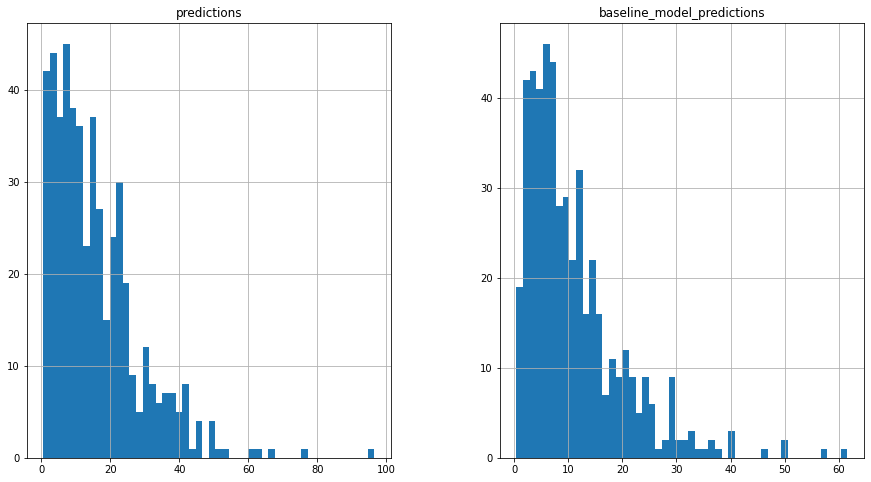

In [148]:
temp = comp.groupby('cusip')[['predictions','baseline_model_predictions']].apply(max_min_f)
print('Average Max-Min Range across all CUSIPS:\n', temp.mean())
print()
print('Std of Max-Min Range across all CUSIPS:\n', temp.std())
temp.hist(figsize=(15, 8), bins = 50);

Where the new_model has a larger range, that range averages 9.1bps. Where the baseline model has a larger range, that range averages 4.7bps. It is also twice as common for the new model to have a larger range (342 v 158)

In [91]:
len(temp[temp.predictions>temp.baseline_model_predictions]), len(temp[temp.predictions<temp.baseline_model_predictions])

(342, 158)

In [92]:
temp[temp.predictions>temp.baseline_model_predictions].diff(axis=1).mean()

predictions                     NaN
baseline_model_predictions   -9.156
dtype: float64

In [93]:
temp[temp.predictions<temp.baseline_model_predictions].diff(axis=1).mean()

predictions                    NaN
baseline_model_predictions   4.740
dtype: float64

Here we look at the average Max-Min range based on original rating and maturity. Predictions are more sensitive for bonds with lower ratings and shorter maturities. Obviously the impact of features like ratings on predictions is non-linear in the network, but this trend likely tells us also that bonds with lower ratings systematically have other features in favor of higher yields. In any case, the predictions of the new model are more sensitive.

In [139]:
comp.groupby(['cusip','original_rating'])\
[['predictions','baseline_model_predictions']].apply(max_min_f)\
.reset_index()\
.groupby('original_rating')\
.mean()

,predictions,baseline_model_predictions
original_rating,,
AAA,14.320,9.505
BBB,18.684,12.805
CCC,32.472,21.623
NR,14.751,11.453


In [326]:
comp.groupby(['cusip','maturity_bucket'])\
[['predictions','baseline_model_predictions']].apply(max_min_f)\
.reset_index()\
.groupby('maturity_bucket')\
.mean()

,predictions,baseline_model_predictions
maturity_bucket,,
"(0.0, 5.0]",23.087,17.145
"(5.0, 10.0]",16.809,12.383
"(10.0, 15.0]",14.900,9.303
"(15.0, 20.0]",14.379,9.152
"(20.0, 30.0]",12.823,8.708
"(30.0, 46.136]",5.353,4.827


In [323]:
temp = comp.groupby(['cusip','original_rating', 'maturity_bucket'])\
[['predictions','baseline_model_predictions']].apply(max_min_f)\
.reset_index()

In [324]:
temp[temp.baseline_model_predictions>temp.predictions].sort_values('baseline_model_predictions', ascending=False).head(20)

,cusip,original_rating,maturity_bucket,predictions,baseline_model_predictions
211,491501DX7,NR,"(0.0, 5.0]",36.510,61.609
157,41420LRE1,BBB,"(0.0, 5.0]",49.885,57.531
25,080401RB0,AAA,"(20.0, 30.0]",22.446,49.999
246,57584XAF8,BBB,"(0.0, 5.0]",44.560,46.915
99,235839CZ8,BBB,"(0.0, 5.0]",37.524,40.577
204,486189GS6,BBB,"(0.0, 5.0]",29.103,40.356
122,34282CLH2,NR,"(10.0, 15.0]",35.861,38.203
76,19648A6C4,NR,"(5.0, 10.0]",12.524,35.102
135,3733846D3,AAA,"(0.0, 5.0]",10.847,33.524
154,413890DK7,BBB,"(30.0, 46.136]",12.189,32.947


We also check the model for consistency - in general, there is little reason for yields to go down if a bond's rating is downgraded. In other words, the relationship between rating and yield should be monotonically increasing. The model is more consistent if this happens. The code below checks for the consistency of yields in hypothetical trades if the yields are increasing from AAA -> BBB -> CCC (we drop NR hypothetical trades). We also check for the more general case where yields are higher when rating is AAA compared to CCC. 

Again, we see that the new model is more consistent. In particular, it is twice more likely to have monotonically increasing yields as rating decreases.

In [211]:
def check_monotonic(df):
    df = df[df.rating!='NR'].sort_values(by='rating')[['predictions','baseline_model_predictions']].diff()
    return ~(df <= 0).any(axis=0)

def check_monotonic_start_end(df):
    df = df[df.rating!='NR'].sort_values(by='rating')[['predictions','baseline_model_predictions']]
    df = df.iloc[-1] - df.iloc[0]
    return df >= 0

is_monotonic = comp.groupby('cusip').apply(check_monotonic)
is_monotonic_start_end = comp.groupby('cusip').apply(check_monotonic_start_end)

display(is_monotic.mean())
display(is_monotonic_start_end.mean())

predictions                  0.550
baseline_model_predictions   0.238
dtype: float64

predictions                  0.884
baseline_model_predictions   0.830
dtype: float64

Look at embeddings: 
(in progress)

In [43]:
def study_embedding(model, top_K = None):
    from scipy.spatial import distance
    rating_embedding_layer = model.get_layer('rating_embed')
    rating_embedding_weights = rating_embedding_layer.get_weights()[0]

    dist_all = []
    for i, arr1 in enumerate(rating_embedding_weights):
        dist = []
        for j, arr2 in enumerate(rating_embedding_weights):
            dist.append(distance.cosine(arr1.reshape(1,-1),
                                          arr2.reshape(1,-1)))
        dist_all.append([x/sum(dist) for x in dist])

    # encoded_ratings = pd.DataFrame({x:[y] for x, y in zip(categorical_feature_values['rating'], rating_embedding_weights)}).T

    encoded_ratings_df = pd.DataFrame(dist_all, 
                 index = categorical_feature_values['rating'],
                columns = categorical_feature_values['rating'])[ratings_sorted].loc[ratings_sorted]

    if top_K:
        for col in encoded_ratings_df.columns:
            print(f'{col}: {sorted(encoded_ratings_df[col].drop(col).sort_values(ascending=True).head(top_K).index.values)}')
        
    return encoded_ratings_df

ratings_sorted = ['AAA',
                     'AA+',
                     'AA',
                     'AA-',
                     'A+',
                     'A',
                     'A-',
                     'BBB+',
                     'BBB',
                     'BBB-',
                     'BB+',
                     'BB',
                     'BB-',
                 'CCC+',
                 'CCC',
                 'CCC-',
                 'CC',
                 'D','NR',
                 'MR']

In [44]:
study_embedding(model, top_K = 5)

AAA: ['AA', 'AA+', 'AA-', 'D', 'NR']
AA+: ['AA', 'AA-', 'AAA', 'CCC-', 'NR']
AA: ['AA+', 'AA-', 'AAA', 'CCC-', 'NR']
AA-: ['A+', 'A-', 'AA', 'AA+', 'AAA']
A+: ['A', 'AA-', 'AAA', 'CC', 'D']
A: ['A+', 'A-', 'BBB+', 'CCC+', 'D']
A-: ['A', 'AA-', 'BB+', 'BBB+', 'CC']
BBB+: ['A', 'A-', 'BBB', 'BBB-', 'CCC+']
BBB: ['A-', 'BBB+', 'BBB-', 'CC', 'CCC+']
BBB-: ['A-', 'BBB', 'BBB+', 'CC', 'MR']
BB+: ['A+', 'A-', 'BBB+', 'CCC', 'CCC+']
BB: ['BB-', 'CCC', 'CCC+', 'CCC-', 'MR']
BB-: ['BB', 'CC', 'CCC', 'CCC+', 'NR']
CCC+: ['BB+', 'BB-', 'BBB', 'CC', 'CCC']
CCC: ['BB', 'BB+', 'BB-', 'CCC+', 'MR']
CCC-: ['AA', 'AA+', 'AAA', 'CCC', 'MR']
CC: ['A-', 'BBB', 'CCC+', 'D', 'NR']
D: ['A', 'A+', 'AA+', 'AAA', 'NR']
NR: ['AA', 'AA+', 'AAA', 'CC', 'D']
MR: ['AA+', 'BB', 'CCC', 'CCC-', 'NR']


,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,BB+,BB,BB-,CCC+,CCC,CCC-,CC,D,NR,MR
AAA,0.000,0.033,0.036,0.040,0.042,0.046,0.048,0.044,0.048,0.045,0.046,0.052,0.054,0.055,0.044,0.038,0.053,0.035,0.038,0.046
AA+,0.034,0.000,0.039,0.042,0.044,0.046,0.052,0.051,0.045,0.048,0.051,0.054,0.048,0.055,0.042,0.029,0.052,0.039,0.036,0.042
AA,0.038,0.039,0.000,0.039,0.043,0.043,0.047,0.046,0.045,0.046,0.048,0.044,0.049,0.052,0.051,0.039,0.055,0.047,0.039,0.045
AA-,0.043,0.043,0.040,0.000,0.040,0.045,0.042,0.048,0.049,0.048,0.048,0.048,0.043,0.047,0.047,0.044,0.051,0.045,0.050,0.043
A+,0.051,0.052,0.050,0.045,0.000,0.041,0.045,0.046,0.050,0.050,0.041,0.043,0.046,0.049,0.053,0.053,0.038,0.034,0.052,0.054
A,0.054,0.052,0.049,0.050,0.040,0.000,0.039,0.039,0.042,0.043,0.046,0.042,0.051,0.034,0.053,0.061,0.041,0.037,0.055,0.052
A-,0.058,0.059,0.053,0.046,0.043,0.039,0.000,0.035,0.040,0.041,0.037,0.042,0.050,0.038,0.054,0.044,0.033,0.047,0.057,0.047
BBB+,0.056,0.062,0.056,0.056,0.048,0.042,0.038,0.000,0.037,0.033,0.041,0.045,0.049,0.033,0.049,0.047,0.038,0.056,0.056,0.047
BBB,0.065,0.058,0.058,0.061,0.055,0.048,0.046,0.039,0.000,0.035,0.043,0.043,0.044,0.028,0.043,0.046,0.035,0.049,0.053,0.053
BBB-,0.058,0.059,0.056,0.057,0.053,0.046,0.044,0.033,0.034,0.000,0.044,0.044,0.043,0.040,0.044,0.052,0.040,0.053,0.050,0.043


# CHARACTERIZING PERFORMANCE ON TEST DATA

In [97]:
test_dataframe['baseline_prediction'] = baseline_model.predict(x_test)
test_dataframe['bottleneck_model_prediction'] = bottleneck_model.predict(x_test)

In [99]:
test_dataframe['baseline_error'] = test_dataframe['new_ys'] - test_dataframe['baseline_prediction']
test_dataframe['bottleneck_model_error'] = test_dataframe['new_ys'] - test_dataframe['bottleneck_model_prediction']

In [102]:
test_dataframe.baseline_error.apply(np.abs).mean(), test_dataframe.bottleneck_model_error.apply(np.abs).mean(), 

(8.082468948374641, 8.176460564573535)

In [ ]:
relevant_cols = [
                 'calc_day_cat',
                 'incorporated_state_code',
                 'is_callable',
                 'days_to_call',
                 'maturity_bucket',
                 'new_real_time_ficc_ycl',
                 'par_traded',
                 'purpose_class',
                 'purpose_sub_class',
                 'rating',
                  ]

In [120]:
test_dataframe['duration'] = test_dataframe[['calc_date','settlement_date']].apply(lambda x: diff_in_days_two_dates(x.calc_date, x.settlement_date), axis = 1)/360
test_dataframe['days_to_maturity_days'] = test_dataframe['days_to_maturity'].apply(lambda x: 10**x)/360

test_dataframe['maturity_bucket'] = pd.cut(test_dataframe['days_to_maturity_days'], bins = [0, 1, 5, 10, 15, 20, 30, test_dataframe.days_to_maturity_days.max()])
test_dataframe['duration_bucket'] = pd.cut(test_dataframe['duration'], bins = [0, 1, 5, 10, 15, 20, 30, test_dataframe.duration.max()])

In [147]:
error_grouping_cols = ['calc_day_cat',
                       'is_callable',
                       'duration_bucket',
                       'maturity_bucket',
                       'purpose_class',
                       'purpose_sub_class',
                       'rating',
                      'incorporated_state_code',]

error_cols = ['baseline_error','bottleneck_model_error']



def summarize_errors(test_dataframe, 
                     error_grouping_cols = error_grouping_cols,
                    error_cols = error_cols):
    for col in error_grouping_cols:
        temp = test_dataframe.groupby(col)[error_cols].agg([lambda x: np.abs(x).mean(), 'std', 'size']).rename({'<lambda_0>':'MAE'}, axis=1)
        temp.drop((error_cols[0], 'size'), axis = 1, inplace = True)
        temp.sort_values((error_cols[1], 'size'), ascending=False, inplace=True)
        if col == 'calc_day_cat':
            temp.index = map(calc_day_cat_dict.get, temp.index)
        display(temp)
        

Calc_day_cat:
- Baseline model is better on next_call_date (.1bps), refund_date (.2bps), maturity_date (.1bps)
- Bottleneck model is better on par_call_date (.7bps), but this is just 500 trades 

is_callable:
- Baseline model is better on both callable and non_callable (.1bps for both) 

Duration_bucket: 
- Baseline model is better on bonds < 20 years, bottleneck model is marginally better on > 20 years
- Same story for maturity_bucket

In [148]:
summarize_errors(test_dataframe)

baseline_error        bottleneck_model_error               
                          MAE    std                    MAE    std    size
maturity_date           7.470 14.279                  7.560 13.914  412649
next_call_date          8.851 14.092                  8.942 14.187  290720
refund_date             9.786 17.413                 10.053 18.137   16694
par_call_date           9.728 15.887                  9.074 15.086     500

baseline_error        bottleneck_model_error               
                       MAE    std                    MAE    std    size
is_callable                                                            
True                 8.048 13.464                  8.135 13.595  481662
False                8.152 15.866                  8.261 15.260  238901

baseline_error        bottleneck_model_error               
                           MAE    std                    MAE    std    size
duration_bucket                                                            
(1.0, 5.0]              10.041 17.384                 10.183 16.940  323799
(5.0, 10.0]              7.100 11.641                  7.141 11.732  226659
(20.0, 30.0]             4.281  7.723                  4.227  8.075   74406
(10.0, 15.0]             7.683 13.573                  7.927 14.057   49184
(15.0, 20.0]             6.227 11.137                  6.345 11.423   37934
(30.0, 46.211]           3.609  7.248                  3.573  7.558    8575
(0.0, 1.0]               6.974  6.150                  5.082  4.201       6

baseline_error        bottleneck_model_error               
                           MAE    std                    MAE    std    size
maturity_bucket                                                            
(5.0, 10.0]              8.858 14.410                  8.989 14.503  192743
(1.0, 5.0]               9.128 17.180                  9.270 16.253  187237
(10.0, 15.0]             8.569 14.264                  8.737 14.542  119585
(20.0, 30.0]             5.822 10.565                  5.771 10.864  117199
(15.0, 20.0]             7.420 12.804                  7.473 13.064   79608
(30.0, 46.892]           4.535  8.132                  4.443  8.304   24191
(0.0, 1.0]                 NaN    NaN                    NaN    NaN       0

baseline_error        bottleneck_model_error               
                         MAE    std                    MAE    std    size
purpose_class                                                            
37.000                 7.986 12.890                  8.106 13.059  135705
50.000                 7.745 12.748                  7.881 13.292   98926
51.000                 7.649 12.397                  7.817 12.602   86623
46.000                 7.973 13.206                  8.045 13.407   68955
48.000                 7.828 12.899                  7.890 13.084   65815
9.000                  8.823 14.854                  8.926 15.093   61258
17.000                 9.379 25.454                  9.351 22.584   50584
18.000                 8.187 13.634                  8.166 13.801   23797
3.000                  7.555 11.944                  7.668 12.232   21855
19.000                 8.433 13.122                  8.590 13.442   19084
5.000                  8.183 12.809                  8.217 12.901   15964
1.000                  7.398 11.780                  7.562 11.929   15331
15.000                 8.067 12.744                  8.081 12.880   12930
25.000                 7.565 12.908                  7.431 12.652    8828
38.000                 8.852 16.890                  8.890 16.484    5032
53.000                 7.527 11.966                  7.692 12.194    4089
20.000                10.149 16.574                 10.156 16.703    3688
8.000                  8.660 14.285                  8.456 13.882    3572
24.000                 7.589 11.355                  7.477 11.206    2918
30.000                 9.508 14.807                  9.670 14.969    1885
6.000                  8.342 12.914                  8.544 13.775    1809
34.000                 8.556 13.619                  8.783 14.110    1699
26.000                 8.918 15.182                  9.143 15.371    1308
13.000                 7.287 11.397                  7.463 11.810    1306
27.000                 8.195 13.011                  8.590 13.543     816
21.000                 7.786 11.821                  8.185 12.559     736
22.000                 7.133 10.499                  7.616 11.179     721
2.000                  7.338 13.775                  7.102 13.364     709
33.000                 6.789  9.681                  7.093 10.117     702
39.000                 8.914 12.517                  8.559 12.065     654
10.000                 7.231 10.170                  7.351 10.433     624
52.000                12.266 21.674                 12.179 19.247     427
14.000                 8.569 14.638                  8.952 15.440     381
16.000                 6.002  8.629                  5.925  8.295     370
28.000                 9.087 15.184                  8.952 14.027     335
11.000                 8.875 12.903                  8.737 12.706     318
4.000                  7.294 12.058                  7.341 12.348     250
36.000                 8.819 13.187                  8.221 11.699     147
43.000                 7.039 10.112                  8.270 11.294     140
7.000                  6.329  8.312                  7.352  9.536     128
29.000                17.326 43.208                 18.044 42.976      50
32.000                 9.970 12.505                  8.516 10.714      38
0.000                  2.900  4.292                  2.101  2.856      29
45.000                10.846 10.487                 11.994 12.105      17
47.000                14.183 17.248                 11.416 11.410       8
23.000                 7.715  8.402                  9.491  3.352       2

baseline_error        bottleneck_model_error               
                             MAE    std                    MAE    std    size
purpose_sub_class                                                            
0.000                      7.870 12.812                  7.990 12.960  147122
51.000                     7.810 12.669                  7.922 12.816  111758
17.000                     7.877 13.189                  7.935 13.409   41065
48.000                     8.869 25.223                  8.848 21.156   36477
129.000                    7.101 12.268                  7.189 12.511   35163
...                          ...    ...                    ...    ...     ...
42.000                     7.313 11.049                  7.345 11.626       6
30.000                    11.493 11.088                 11.992 12.364       5
37.000                    35.291 28.820                 18.888 22.462       4
3.000                      0.680    NaN                  9.510    NaN       1
43.000                    10.751    NaN                 10.114    NaN       1

[97 rows x 5 columns]

baseline_error         bottleneck_model_error                
                  MAE     std                    MAE     std    size
rating                                                              
MR              8.552  15.702                  8.651  16.205  127054
AA              7.805  12.605                  7.940  12.863  126458
AA+             7.416  11.586                  7.528  11.822  111690
AAA             7.311  12.001                  7.458  12.249  109554
AA-             7.897  12.672                  7.972  12.774  101485
A+              8.482  13.497                  8.569  13.592   56774
A               8.536  13.933                  8.554  14.074   38537
A-              8.665  14.538                  8.659  14.639   25106
BBB+           10.815  17.610                 10.754  17.570   12178
BBB            10.985  17.939                 10.789  17.717    4755
BBB-           11.066  18.780                 11.327  19.452    3044
NR             13.185  27.896                 12.803  20.881    2550
BB+            15.730  27.565                 15.763  28.317     873
BB             23.726  40.040                 28.469  56.387     259
BB-            35.513  69.528                 33.566  76.156     113
B             278.381 476.910                222.729 391.151      53
B-              6.837  12.606                  5.306  10.906      52
B+             55.521  91.994                 61.333 109.007      23
CCC            33.631  56.567                 48.182  80.372       5

baseline_error        bottleneck_model_error          \
                                   MAE    std                    MAE     std   
incorporated_state_code                                                        
CA                               8.466 13.830                  8.642  14.116   
TX                               7.727 13.430                  7.786  13.136   
NY                               7.835 12.912                  7.896  13.197   
PA                               9.445 26.627                  9.438  22.012   
FL                               7.852 12.958                  7.891  12.957   
NJ                               8.531 13.743                  8.687  13.944   
OH                               7.699 12.670                  7.756  12.716   
IL                               9.512 15.286                  9.547  15.622   
MA                               7.552 12.383                  7.683  12.643   
MI                               7.975 12.519                  8.051  12.707   
WA                               7.695 12.134                  7.849  12.331   
CO                               7.954 12.377                  7.945  12.340   
VA                               6.965 11.190                  7.060  11.371   
NC                               7.308 12.167                  7.322  12.366   
WI                               7.974 14.326                  8.186  14.876   
GA                               8.094 14.712                  8.185  15.225   
MD                               7.218 11.977                  7.352  12.286   
IN                               8.393 13.672                  8.486  13.805   
MN                               8.177 13.001                  8.217  13.177   
OR                               8.302 20.317                  8.440  20.930   
AZ                               8.212 13.472                  8.366  13.626   
CT                               8.596 14.530                  8.782  14.863   
MO                               7.593 13.809                  7.616  14.195   
AL                               7.959 12.343                  8.118  12.546   
SC                               8.014 12.992                  8.048  13.164   
LA                               7.722 12.663                  7.817  13.010   
TN                               8.132 12.932                  7.991  12.626   
KY                               8.014 13.513                  8.058  13.771   
UT                               6.873 10.435                  6.869  10.575   
OK                               9.379 18.527                  9.538  19.871   
DC                               7.050 11.046                  7.117  11.168   
NV                               7.219 10.808                  7.349  11.032   
KS                               9.108 15.792                  9.282  16.022   
IA                               7.830 13.162                  7.918  13.305   
HI                               7.694 11.785                  7.949  12.385   
AR                               6.942 11.691                  7.148  12.232   
NE                               7.817 12.151                  7.881  12.520   
WV                               7.209 12.547                  7.075  12.471   
ME                               8.280 12.773                  8.335  13.290   
NM                               8.164 12.758                  8.185  12.722   
MS                               8.340 13.367                  8.393  13.459   
RI                               7.867 11.958                  8.184  12.741   
NH                               7.153 13.089                  7.097  13.564   
AK                               9.567 14.630                  9.795  15.348   
ID                               7.298 11.746                  7.236  11.618   
DE                               7.466 12.288                  7.571  12.502   
ND                               8.853 14.032                  8.578  13.468   
SD                      

# Moodys

In [160]:
rating_cols = ['rating', 'sp_stand_alone', 'sp_long', 'moodys_long']

In [269]:
print(f"sp_long and sp_stand_alone and Moodys not NA: {len(train_dataframe[(train_dataframe.sp_long=='NR')  & (train_dataframe.sp_stand_alone=='NR')][rating_cols])/len(train_dataframe):.4f}")
print(f"sp_long and sp_stand_alone NA: {len(train_dataframe[(train_dataframe.sp_long=='NR')  & (train_dataframe.sp_stand_alone=='NR')][rating_cols])/len(train_dataframe):.4f}")
print(f"sp_long and sp_stand_alone NA but Moodys available: {len(train_dataframe[(train_dataframe.sp_long=='NR') & (train_dataframe.sp_stand_alone=='NR') & (~train_dataframe.moodys_long.isna())][rating_cols])/len(train_dataframe):.4f}")
print(f"Moodys not NA: {len(train_dataframe[(train_dataframe.moodys_long.isna())][rating_cols])/len(train_dataframe):.4f}")
print(f"Moodys WR: {len(train_dataframe[(train_dataframe.moodys_long == 'WR')])/len(train_dataframe):.4f}")

sp_long and sp_stand_alone NA: 0.0036
sp_long and sp_stand_alone NA but Moodys available: 0.0014
Moodys not NA: 0.2744
Moodys WR: 0.0040


In [212]:
temp = train_dataframe.groupby(['cusip','rating']).size().droplevel(1)
duplicated_cusips = set(temp[temp.index.duplicated()].index)
cusips_with_diff_ratings = train_dataframe[train_dataframe.cusip.isin(duplicated_cusips)].sort_values(['cusip', 'trade_date'], ascending=True) #[['rtrs_control_number', 'trade_date', 'cusip', 'yield', 'rating']]
print(f'% trades in cusips with ratings change: {len(cusips_with_diff_ratings)/len(train_dataframe)*100:.3f}')

% trades in cusips with ratings change: 3.669


In [205]:
cusips_with_diff_ratings.groupby('cusip').apply(lambda x: len(x.rating.unique())).value_counts()

2    3218
3       5
dtype: int64

In [208]:
cusips_with_diff_ratings.groupby('cusip').apply(lambda x: len(x.rating.unique())).sort_values().tail(6)

# ['452151LF8', 
# '464080LY4', 
# '464080MA5', 
# '464080MX5', 
# '167505NH5'] 

cusip
517697AH1    2
452151LF8    3
464080LY4    3
464080MA5    3
464080MX5    3
167505NH5    3
dtype: int64

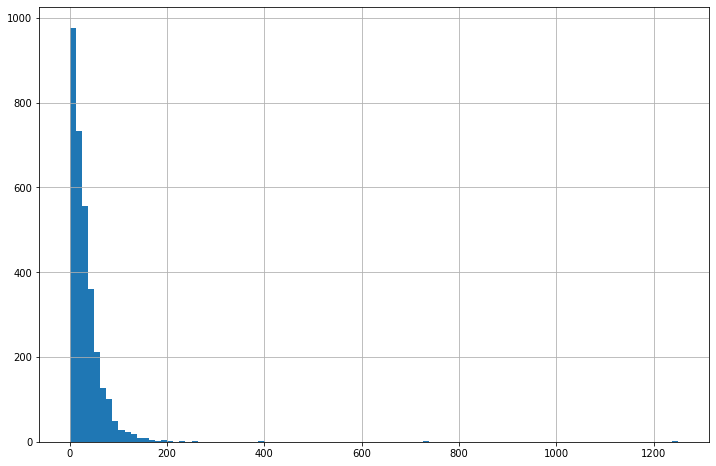

In [221]:
temp = cusips_with_diff_ratings.groupby(['cusip','rating'])['yield'].apply(max).groupby('cusip').apply(lambda x: x.max() - x.min())
temp.hist(bins=100, figsize=(12,8));

In [231]:
train_dataframe[train_dataframe.cusip == '709224FR5'][['cusip', 'yield', 'trade_datetime','rating']].sort_values('trade_datetime')

,cusip,yield,trade_datetime,rating
100173,709224FR5,290.100,2023-01-05 10:46:00,A+
99987,709224FR5,290.100,2023-01-05 10:46:01,A+
351676,709224FR5,272.000,2023-01-18 14:01:51,A+
351615,709224FR5,272.000,2023-01-18 14:02:40,A+
351616,709224FR5,272.000,2023-01-18 14:02:40,A+
351618,709224FR5,272.000,2023-01-18 14:02:40,A+
351619,709224FR5,272.000,2023-01-18 14:02:40,A+
351620,709224FR5,272.000,2023-01-18 14:02:40,A+
351634,709224FR5,272.000,2023-01-18 14:02:40,A+
610202,709224FR5,270.000,2023-01-27 14:40:47,AA-


# Charles' Code

In [10]:
%%time
ratingdict = dict(zip(processed_data.rtrs_control_number, processed_data.rating) )

CPU times: user 2.04 s, sys: 44.5 ms, total: 2.08 s
Wall time: 2.07 s


In [11]:
IG = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-", ]
junk = ["BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-", "CC", "C"]
norating = ["nan", "MR", "NR"]
    
ratings = IG + junk + norating

def betterthan(a,b): return ratings.index(a) < ratings.index(b)
    
print( ratings.index("BB+"), betterthan("B-", "B-") )

10 False


In [12]:
def ratingflag(data):
    a = data.last_rtrs_control_number.map(ratingdict).astype(str)
    missinga = a.isin(["nan"])
    noa = a.isin(["MR", "NR"])
    yesa = a.isin(IG + junk)

    b = data.rating.astype(str)
    nob = b.isin(["MR", "NR"])
    yesb = b.isin(IG + junk)

    upgraded = list( map(betterthan, b, a) )
    downgraded = list( map(betterthan, a, b) )

    flag = pd.Series("error", index = data.index)
    flag[missinga] = "prev unknown"
    flag[noa & nob] = "both unknown" 
    flag[noa & yesb] = "initiated"
    flag[yesa & nob] = "withdrawn" # this is worse than downgraded
    flag[yesa & yesb & (a == b)] = "unchanged"
    flag[yesa & yesb & upgraded] = "upgraded"
    flag[yesa & yesb & downgraded] = "downgraded"
    return flag.astype('category')

In [16]:
%%time
processed_data['ratingchange'] = ratingflag(processed_data)
processed_data.ratingchange.value_counts(dropna=False)

CPU times: user 17.5 s, sys: 203 ms, total: 17.7 s
Wall time: 17.9 s


unchanged       3282629
both unknown     695243
prev unknown     511095
upgraded           5906
downgraded         1063
initiated           555
withdrawn           292
Name: ratingchange, dtype: int64

In [20]:
cusip_rating_change_counts = processed_data.groupby('cusip')['ratingchange'].nunique()

In [22]:
display(cusip_rating_change_counts.value_counts())
cusip_rating_change_counts.sort_values(ascending=False).head(10)

2    275057
1     29308
3      4129
4       281
5         3
Name: ratingchange, dtype: int64

cusip
544532GN8    5
167505NH5    5
452151LF8    5
546475QQ0    4
366375PV9    4
243322BD5    4
243322BE3    4
1301786D3    4
24880DLM6    4
24880DLK0    4
Name: ratingchange, dtype: int64

In [141]:
len(processed_data[processed_data.cusip.isin(cusip_rating_change_counts[cusip_rating_change_counts>3].index)])

13620

In [134]:
def displayrows(df):
    N = len(df)
    i = 0
    while i < N//50:
        display(df[['rating', 'ratingchange', 'trade_datetime']][i*50:(i+1)*50])
        i+=1
    if i and N%50:
        display(df[['rating', 'ratingchange', 'trade_datetime']][-(N%50):])

In [136]:
displayrows(processed_data[processed_data.cusip=='452151LF8'])

,rating,ratingchange,trade_datetime
1514,MR,both unknown,2023-06-30 15:57:48
1776,MR,both unknown,2023-06-30 15:53:06
4393,MR,both unknown,2023-06-30 15:06:38
5228,MR,both unknown,2023-06-30 14:54:41
17145,MR,both unknown,2023-06-30 12:19:38
17632,MR,both unknown,2023-06-30 12:14:46
19586,MR,both unknown,2023-06-30 11:55:00
19592,MR,both unknown,2023-06-30 11:55:00
21062,MR,both unknown,2023-06-30 11:44:21
23555,MR,both unknown,2023-06-30 11:29:20


,rating,ratingchange,trade_datetime
163661,MR,both unknown,2023-06-27 09:04:58
163662,MR,both unknown,2023-06-27 09:04:58
163739,MR,both unknown,2023-06-27 09:00:00
167621,MR,both unknown,2023-06-26 16:04:52
184699,MR,both unknown,2023-06-26 12:49:00
190538,MR,withdrawn,2023-06-26 11:58:13
217073,A-,unchanged,2023-06-23 13:29:41
217076,A-,unchanged,2023-06-23 13:29:41
217077,A-,unchanged,2023-06-23 13:29:41
246955,A-,unchanged,2023-06-22 15:40:21


,rating,ratingchange,trade_datetime
415537,MR,both unknown,2023-06-15 14:54:48
415540,MR,both unknown,2023-06-15 14:54:47
423555,MR,both unknown,2023-06-15 13:37:00
424181,MR,both unknown,2023-06-15 13:28:43
427500,MR,both unknown,2023-06-15 12:54:25
427501,MR,both unknown,2023-06-15 12:54:25
427502,MR,both unknown,2023-06-15 12:54:25
432731,MR,both unknown,2023-06-15 12:08:02
432744,MR,both unknown,2023-06-15 12:08:00
434961,MR,both unknown,2023-06-15 11:48:22


,rating,ratingchange,trade_datetime
890221,MR,both unknown,2023-05-31 13:25:41
897600,MR,both unknown,2023-05-31 12:32:32
900254,MR,both unknown,2023-05-31 12:04:26
900256,MR,both unknown,2023-05-31 12:04:25
900258,MR,both unknown,2023-05-31 12:04:25
900259,MR,both unknown,2023-05-31 12:04:25
918753,MR,both unknown,2023-05-30 16:25:02
918891,MR,both unknown,2023-05-30 16:21:50
918957,MR,both unknown,2023-05-30 16:21:00
937591,MR,both unknown,2023-05-30 13:33:22


,rating,ratingchange,trade_datetime
1356387,MR,both unknown,2023-05-15 12:48:12
1359862,MR,withdrawn,2023-05-15 12:20:00
1419123,A-,unchanged,2023-05-11 14:53:44
1469068,A-,unchanged,2023-05-10 13:02:04
1493826,A-,unchanged,2023-05-09 16:00:16
1493992,A-,initiated,2023-05-09 15:58:51
1599121,MR,both unknown,2023-05-04 16:24:09
1599210,MR,both unknown,2023-05-04 16:21:45
1634728,MR,both unknown,2023-05-04 09:39:23
1636852,MR,both unknown,2023-05-04 08:25:59


,rating,ratingchange,trade_datetime
1879246,A-,unchanged,2023-04-25 15:00:23
1879247,A-,unchanged,2023-04-25 15:00:23
1887603,A-,unchanged,2023-04-25 13:32:28
1887835,A-,unchanged,2023-04-25 13:29:53
1930194,A-,initiated,2023-04-24 12:58:23
1930195,A-,initiated,2023-04-24 12:58:23
1951406,MR,both unknown,2023-04-21 15:41:47
1951407,MR,both unknown,2023-04-21 15:41:47
1971668,MR,both unknown,2023-04-21 11:15:45
1979262,MR,both unknown,2023-04-21 09:20:00


,rating,ratingchange,trade_datetime
2418625,MR,both unknown,2023-04-04 12:27:49
2436649,MR,both unknown,2023-04-03 16:03:11
2436650,MR,both unknown,2023-04-03 16:03:11
2448796,MR,both unknown,2023-04-03 13:34:00
2454584,MR,both unknown,2023-04-03 12:19:57
2454587,MR,both unknown,2023-04-03 12:19:57
2454751,MR,withdrawn,2023-04-03 12:18:16
2471176,A-,unchanged,2023-03-31 16:01:00
2471320,A-,unchanged,2023-03-31 16:00:00
2477047,A-,unchanged,2023-03-31 14:21:15


,rating,ratingchange,trade_datetime
2649017,MR,both unknown,2023-03-24 14:07:36
2656237,MR,both unknown,2023-03-24 12:27:34
2656238,MR,both unknown,2023-03-24 12:27:34
2656267,MR,both unknown,2023-03-24 12:27:29
2656268,MR,both unknown,2023-03-24 12:27:29
2670745,MR,both unknown,2023-03-24 09:20:00
2675095,MR,both unknown,2023-03-23 16:06:06
2675096,MR,both unknown,2023-03-23 16:06:06
2675466,MR,both unknown,2023-03-23 16:00:00
2684026,MR,both unknown,2023-03-23 14:17:26


,rating,ratingchange,trade_datetime
2978576,A-,unchanged,2023-03-13 13:58:43
2982279,A-,initiated,2023-03-13 13:10:48
2982280,A-,initiated,2023-03-13 13:10:48
3024206,MR,both unknown,2023-03-10 10:25:19
3024211,MR,both unknown,2023-03-10 10:25:14
3025382,MR,both unknown,2023-03-10 10:08:44
3025385,MR,both unknown,2023-03-10 10:08:44
3027331,MR,both unknown,2023-03-10 09:21:47
3027962,MR,both unknown,2023-03-10 08:55:34
3027963,MR,both unknown,2023-03-10 08:55:34


,rating,ratingchange,trade_datetime
3228932,A-,unchanged,2023-03-02 15:41:40
3228933,A-,unchanged,2023-03-02 15:41:40
3228934,A-,unchanged,2023-03-02 15:41:40
3228935,A-,unchanged,2023-03-02 15:41:40
3228936,A-,unchanged,2023-03-02 15:41:40
3230189,A-,unchanged,2023-03-02 15:25:39
3230280,A-,unchanged,2023-03-02 15:24:52
3230317,A-,unchanged,2023-03-02 15:24:25
3230650,A-,unchanged,2023-03-02 15:20:42
3230697,A-,unchanged,2023-03-02 15:20:04


,rating,ratingchange,trade_datetime
3404219,MR,both unknown,2023-02-24 15:55:29
3404220,MR,both unknown,2023-02-24 15:55:29
3404221,MR,both unknown,2023-02-24 15:55:29
3404222,MR,both unknown,2023-02-24 15:55:29
3404223,MR,both unknown,2023-02-24 15:55:29
3404224,MR,both unknown,2023-02-24 15:55:29
3412719,MR,both unknown,2023-02-24 14:09:36
3412720,MR,both unknown,2023-02-24 14:09:36
3412721,MR,both unknown,2023-02-24 14:09:36
3415268,MR,both unknown,2023-02-24 13:41:42


,rating,ratingchange,trade_datetime
3786481,MR,both unknown,2023-02-10 14:39:07
3786483,MR,both unknown,2023-02-10 14:39:06
3786484,MR,both unknown,2023-02-10 14:39:05
3786485,MR,both unknown,2023-02-10 14:39:05
3823930,MR,both unknown,2023-02-09 13:59:18
3823993,MR,both unknown,2023-02-09 13:58:24
3823994,MR,both unknown,2023-02-09 13:58:24
3854269,MR,both unknown,2023-02-08 15:38:04
3860070,MR,both unknown,2023-02-08 14:40:59
3866975,MR,both unknown,2023-02-08 13:25:13


,rating,ratingchange,trade_datetime
4116669,BBB+,unchanged,2023-01-31 09:40:18
4116892,BBB+,unchanged,2023-01-31 09:34:38
4117074,BBB+,unchanged,2023-01-31 09:32:10
4121047,BBB+,unchanged,2023-01-30 16:17:51
4121048,BBB+,unchanged,2023-01-30 16:17:51
4128541,BBB+,initiated,2023-01-30 14:45:51
4128542,BBB+,initiated,2023-01-30 14:45:51
4128543,BBB+,initiated,2023-01-30 14:45:51
4159999,MR,both unknown,2023-01-27 16:00:15
4169839,MR,both unknown,2023-01-27 13:30:19


,rating,ratingchange,trade_datetime
4481447,BBB+,unchanged,2023-01-18 09:29:00
4481533,BBB+,initiated,2023-01-18 09:26:56
4536493,MR,both unknown,2023-01-13 12:58:27
4548936,MR,both unknown,2023-01-13 10:40:01
4599559,MR,both unknown,2023-01-11 16:00:00
4644111,MR,both unknown,2023-01-10 15:47:27
4644118,MR,both unknown,2023-01-10 15:47:27
4645398,MR,both unknown,2023-01-10 15:33:19
4645399,MR,both unknown,2023-01-10 15:33:19
4651893,MR,both unknown,2023-01-10 14:20:34


,rating,ratingchange,trade_datetime
4881249,BBB+,prev unknown,2023-01-03 11:21:51
4881250,BBB+,prev unknown,2023-01-03 11:21:50
4881252,BBB+,prev unknown,2023-01-03 11:21:50


In [120]:
[['rating', 'ratingchange', 'trade_datetime']][:50]
processed_data[processed_data.cusip=='544532GN8'][['rating', 'ratingchange', 'trade_datetime']][50:]

,rating,ratingchange,trade_datetime
1873069,MR,both unknown,2023-04-25 16:19:12
1877212,MR,both unknown,2023-04-25 15:18:54
1890770,MR,both unknown,2023-04-25 13:01:23
1890780,MR,both unknown,2023-04-25 13:01:23
2116935,MR,both unknown,2023-04-17 14:19:57
2136279,MR,both unknown,2023-04-17 10:44:59
2330167,MR,both unknown,2023-04-06 15:28:33
2371341,MR,both unknown,2023-04-05 14:15:55
2611843,MR,both unknown,2023-03-27 15:56:37
2611844,MR,both unknown,2023-03-27 15:56:37


In [116]:
processed_data[processed_data.cusip=='167505NH5'][['rating','trade_datetime']][:50]

,rating,trade_datetime
9090,BB+,2023-06-30 13:53:01
9091,BB+,2023-06-30 13:53:01
54308,BB+,2023-06-29 13:13:24
54309,BB+,2023-06-29 13:13:24
783902,BB+,2023-06-02 16:29:01
784066,BB+,2023-06-02 16:23:48
784092,BB+,2023-06-02 16:23:14
819330,BB+,2023-06-02 09:54:49
819331,BB+,2023-06-02 09:54:49
946514,BB+,2023-05-30 12:11:26


In [38]:
processed_data['last_rtrs_control_number'] = processed_data['last_rtrs_control_number'].astype(int, errors='ignore')

In [98]:
display(processed_data[processed_data.cusip=='07133AHZ8'][['cusip','rtrs_control_number','rating','trade_datetime', 'last_rtrs_control_number', 'ratingchange']].sort_values('trade_datetime')[:50])
display(processed_data[processed_data.cusip=='07133AHZ8'][['cusip','rtrs_control_number','rating','trade_datetime', 'last_rtrs_control_number', 'ratingchange']].sort_values('trade_datetime')[50:])

,cusip,rtrs_control_number,rating,trade_datetime,last_rtrs_control_number,ratingchange
4228446,07133AHZ8,2023012601066600,MR,2023-01-26 09:54:24,2022112210858300.000,prev unknown
4228440,07133AHZ8,2023012601101500,MR,2023-01-26 09:54:25,2022112210858300.000,prev unknown
463166,07133AHZ8,2023061407863300,MR,2023-06-14 14:21:10,2023012601101500.000,both unknown
462757,07133AHZ8,2023061407963200,MR,2023-06-14 14:25:09,2023061407863300.000,both unknown


,cusip,rtrs_control_number,rating,trade_datetime,last_rtrs_control_number,ratingchange


In [40]:
processed_data[processed_data.cusip=='544532GN8'][['rating','trade_datetime']][50:]

,rating,trade_datetime
1873069,MR,2023-04-25 16:19:12
1877212,MR,2023-04-25 15:18:54
1890770,MR,2023-04-25 13:01:23
1890780,MR,2023-04-25 13:01:23
2116935,MR,2023-04-17 14:19:57
2136279,MR,2023-04-17 10:44:59
2330167,MR,2023-04-06 15:28:33
2371341,MR,2023-04-05 14:15:55
2611843,MR,2023-03-27 15:56:37
2611844,MR,2023-03-27 15:56:37


In [50]:
CATEGORICAL_FEATURES

['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']

In [53]:
print(CATEGORICAL_FEATURES)

for col in CATEGORICAL_FEATURES:
    display(processed_data.groupby('cusip')[col].nunique().value_counts())

['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']


1    304107
2      4666
3         5
Name: rating, dtype: int64

1    308777
2         1
Name: incorporated_state_code, dtype: int64

3    222854
2     70162
1     15762
Name: trade_type, dtype: int64

1    307753
2      1025
Name: purpose_class, dtype: int64

In [76]:
col = 'purpose_class'
x = processed_data.groupby('cusip')[col].nunique()
weird_cusips = x.index[x>1].values

In [77]:
weird_cusips

array(['00344NNL4', '00344NNM2', '00344NNQ3', ..., '975673HR8',
       '975673HS6', '975673HT4'], dtype=object)

In [102]:
def check_cusip_categoricals(cusip):
    display(processed_data[processed_data.cusip==cusip][['cusip','trade_datetime','rating', 'incorporated_state_code', 'trade_type', 'purpose_class']])

In [106]:
check_cusip_categoricals('07133AHT2')

,cusip,trade_datetime,rating,incorporated_state_code,trade_type,purpose_class
14646,07133AHT2,2023-06-30 12:43:42,MR,NY,P,46.000
264196,07133AHT2,2023-06-22 12:47:00,MR,NY,P,46.000
387135,07133AHT2,2023-06-16 12:43:53,MR,NY,P,46.000
629434,07133AHT2,2023-06-08 12:47:57,MR,NY,S,46.000
629436,07133AHT2,2023-06-08 12:47:53,MR,NY,D,46.000
629437,07133AHT2,2023-06-08 12:47:53,MR,NY,D,46.000
629506,07133AHT2,2023-06-08 12:47:00,MR,NY,D,46.000
711588,07133AHT2,2023-06-06 14:06:07,MR,NY,S,46.000
711647,07133AHT2,2023-06-06 14:05:58,MR,NY,D,46.000
760378,07133AHT2,2023-06-05 13:07:31,MR,NY,P,46.000


In [111]:
cusip_series = ['07133AGM8', '07133AGN6',
'07133AGP1', '07133AGQ9', '07133AGR7', '07133AGS5', '07133AGT3',
'07133AHE5', '07133AHJ4', '07133AHK1', '07133AHQ8', '07133AHR6',
'07133AHS4', '07133AHT2', '07133AHV7', '07133AHW5', '07133AHX3',
'07133AHZ8']

In [113]:
def myfunc(df):
    return df.sort_values(by='trade_datetime', ascending=True).iloc[0]
    

processed_data[processed_data.cusip.isin(cusip_series)].groupby('cusip')[['trade_datetime']+CATEGORICAL_FEATURES].apply(myfunc)

,trade_datetime,rating,incorporated_state_code,trade_type,purpose_class
cusip,,,,,
07133AGM8,2023-01-05 15:17:33,MR,NY,P,19.000
07133AGN6,2023-01-13 11:42:03,MR,NY,P,19.000
07133AGP1,2023-01-03 14:47:34,MR,NY,P,19.000
07133AGQ9,2023-01-13 12:28:55,MR,NY,P,19.000
07133AGR7,2023-01-27 15:28:26,MR,NY,D,19.000
07133AGS5,2023-02-07 12:23:35,MR,NY,P,19.000
07133AGT3,2023-01-12 12:14:33,MR,NY,D,19.000
07133AHE5,2023-01-03 14:23:23,MR,NY,P,19.000
07133AHJ4,2023-01-05 14:24:57,MR,NY,D,19.000


In [88]:
for cusip in weird_cusips[10:]:
    x = processed_data[processed_data.cusip == cusip][['rtrs_control_number', 'trade_datetime', 'yield']+ CATEGORICAL_FEATURES].purpose_class.unique()
    print(f'{cusip}: {str(x)}') 

041838EY5: [50.  7.]
041838FU2: [50.  7.]
047681NH0: [46. 26.]
047681NJ6: [46. 26.]
047681NM9: [46. 26.]
047681NN7: [46. 26.]
047681NQ0: [46. 26.]
0502134N4: [53. 46.]
0502134Y0: [53. 46.]
0502134Z7: [53. 46.]
0502135A1: [53. 46.]
0502135M5: [53. 46.]
057864AV2: [53.  3.]
07133AGM8: [46. 19.]
07133AGN6: [46. 19.]
07133AGP1: [46. 19.]
07133AGQ9: [46. 19.]
07133AGR7: [46. 19.]
07133AGS5: [46. 19.]
07133AGT3: [46. 19.]
07133AHE5: [46. 19.]
07133AHJ4: [46. 19.]
07133AHK1: [46. 19.]
07133AHQ8: [46. 19.]
07133AHR6: [46. 19.]
07133AHS4: [46. 19.]
07133AHT2: [46. 19.]
07133AHV7: [46. 19.]
07133AHW5: [46. 19.]
07133AHX3: [46. 19.]
07133AHZ8: [46. 19.]
076059KG8: [ 3. 15.]
081518BT8: [46. 37.]
082426MR5: [26. 34.]
087672DU2: [48. 15.]
09517DAH1: [53.  3.]
100853J84: [51.  0.]
106205TR8: [51. 48.]
106205UD7: [ 3. 48.]
106205UG0: [ 3. 48.]
106205UM7: [ 3. 48.]
106205UR6: [ 3. 48.]
106205UU9: [ 3. 48.]
113807AQ4: [20. 46.]
113807BF7: [20. 46.]
113807BH3: [20. 46.]
113807BM2: [20. 46.]
113807BN0: [2

KeyboardInterrupt: 

In [94]:
processed_data.groupby(['purpose_class','purpose_sub_class','use_of_proceeds','muni_security_type']).size().reset_index().sort_values(['purpose_class'], ascending=False)

,purpose_class,purpose_sub_class,use_of_proceeds,muni_security_type,0
1988,50.000,129.000,72,8,141
1850,50.000,80.000,65,8,96
1860,50.000,104.000,35,8,18
1859,50.000,104.000,20,8,571
1858,50.000,104.000,20,6,183
...,...,...,...,...,...
65,1.000,78.000,20,8,7474
66,1.000,78.000,35,8,4807
67,1.000,78.000,43,8,313
68,1.000,78.000,53,8,45
